In [1]:
# data science libraries
import numpy as np
import pandas as pd
import gseapy as gp
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr

# machine learning libraries
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.preprocessing import StandardScaler
import joblib
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import KFold

# data visualization libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from gseapy import enrichment_map
import networkx as nx

# general tools
import json
import re 
import csv
from roman import toRoman, fromRoman
from tqdm import tqdm
from collections import defaultdict

In [2]:
print('The gseapy version is {}.'.format(gp.__version__))

The gseapy version is 1.1.1.


# Pre-processing steps 

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#get cell annotations
annot = pd.read_csv('cell-annotation.csv')
#get cell type categories
cells_cat = list(annot['cell.type'].unique())

with open('batch_list.txt') as f:
    batch_list = f.readlines()
#cleaning list    
batches = []
for b in batch_list:
    b = b.strip('/\n')
    batches.append(b)

def overlap(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [5]:
# Initialize a set to store all unique genes
unique_genes = set()

# Load genes from each cell type and add to the set
for cell_type in tqdm(cells_cat, desc="Loading genes by cell type"):  
    genes_list = np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True)
    unique_genes.update(genes_list)

# Separate mitochondrial and nuclear genes
MT_genes = sorted([gene for gene in unique_genes if gene.startswith('MT-')])
nuc_genes = sorted(unique_genes - set(MT_genes))

# Compute overlapping genes across all cell types
overlap_genes = unique_genes.copy()
for cell_type in tqdm(cells_cat, desc="Computing overlap"):
    genes_list = set(np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True))
    overlap_genes = overlap(overlap_genes, genes_list)

overlap_genes = sorted(overlap_genes)

Computing overlap: 100%|██████████| 16/16 [00:00<00:00, 651.76it/s]


In [6]:
MT_genes = [gene for gene in overlap_genes if gene.startswith('MT-')]
nuc_genes = [gene for gene in overlap_genes if not gene.startswith('MT-')]

print("Mitochondrial genes:")
for gene in MT_genes:
    print(gene)


Mitochondrial genes:
MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


## Useful functions 

In [ ]:
def drop_cols(cleaned_df,list_of_cols):
    constant_cols_count = 0
    nearly_constant_cols_count = 0
    cleaned_df = cleaned_df[list_of_cols]
    #now check if most common value of each col appears 90% of the time or more
    #if so, drop that column
    for cur_col in list_of_cols:
        # print(cur_col)
        if cleaned_df[cur_col].nunique() == 1: #check number of unique vals, if its all 1 then drop the column
            cleaned_df = cleaned_df.drop(cur_col, axis=1)
            # print('dropped bc 1 val:', cur_col)
            # print('constant: ', cur_col)
            constant_cols_count += 1
        elif cleaned_df[cur_col].nunique() > 1: #check number of unique vals, if its >1 then drop the column if >=90% of values are most common value
            #print(‘checking:’, cur_col)
            most_common_val_count = cleaned_df[cur_col].sort_values(ascending=False).value_counts().iloc[0] #number of times the most common value occurs
            total_val_count = cleaned_df[cur_col].sort_values(ascending=False).value_counts().sum() #total number of values in column
            percent_most_common_val = most_common_val_count/total_val_count #percentage of entries the most common entry accounts for
            if percent_most_common_val >= 0.90: #drop if >=99%
                print('dropped bc >=90%:', cur_col)
                cleaned_df = cleaned_df.drop(cur_col, axis=1)
                # print('90 percent constant: ', cur_col)
                nearly_constant_cols_count += 1
    return cleaned_df

def deconf(dff,conf):
        df = dff.copy()
        for col in df.columns:
                conf_with_bias = sm.add_constant(conf)
                model = sm.OLS(df[col],conf_with_bias).fit()
                df[col] = model.resid
        return df

def zscore(dff,col):
        df = dff.copy()
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
        return df

#function for missing data imputation
def my_impute(dff, col):
    new_df = dff.copy()
    arr = pd.to_numeric(new_df[col])
    arr = np.array(arr)
    b_nan = np.isnan(arr)
    b_negative = arr < 0
    b_bad = b_nan | b_negative
    arr[b_bad] = np.random.choice(arr[~b_bad], np.sum(b_bad))
    new_df[col] = arr
    return new_df

## Clinical Variable

In [8]:
# ---------------------- Load clinical data ----------------------
clinic = pd.read_csv('ROSMAP_clinical_combined_cleaned.csv', index_col=0)
print(f'Clinical data shape: {clinic.shape}')

# Remove columns not needed for analysis
clinic_cols = [col for col in clinic.columns if col not in ['Study', 'individualID_y']]

# ---------------------- Separate AD and healthy individuals ----------------------
# AD patients
clin_ad = clinic.loc[clinic.dcfdx_ad == 1]
ad_clin_df = drop_cols(clin_ad, clinic_cols)

# Columns to keep for AD analysis / classification
ad_cols = list(ad_clin_df.columns) + [
    'dcfdx_ad', 'dcfdx_mci', 'dcfdx_other', 'e4_status',
    'cogdx_ad', 'cogdx_mci', 'cogdx_other'
]

# Healthy individuals
clin_healthy = clinic.loc[clinic.dcfdx_ad == 0]
healthy_clin_df = drop_cols(clin_healthy, clinic_cols)

# Columns to keep for healthy analysis / classification
hc_cols = list(healthy_clin_df.columns) + [
    'dcfdx_ad', 'dcfdx_other', 'e4_status',
    'cogdx_ad', 'cogdx_mci', 'cogdx_other'
]

# ---------------------- Identify overlapping columns ----------------------
all_clin_cols = overlap(hc_cols, ad_cols)  # Only keep columns present in both groups
all_clin_cols.append('cogdx')  # Add final column for analysis

# Remove duplicates while preserving order
seen = set()
no_dup = []
for col in all_clin_cols:
    if col not in seen:
        no_dup.append(col)
        seen.add(col)
    else:
        print(f'Found duplicate: {col}')

all_clin_cols = no_dup
print(f'Final clinical columns ({len(all_clin_cols)}): {all_clin_cols}')


Clinical data shape: (424, 64)
dropped bc >=90%: APOE_22.0
dropped bc >=90%: APOE_24.0
dropped bc >=90%: APOE_44.0
dropped bc >=90%: cogdx_ad
dropped bc >=90%: cogdx_other
dropped bc >=90%: APOE_22.0
dropped bc >=90%: APOE_24.0
dropped bc >=90%: APOE_44.0
dropped bc >=90%: cogdx_ad
dropped bc >=90%: cogdx_other
dropped bc >=90%: dcfdx_other
Found duplicate: e4_status
Found duplicate: cogdx_mci
Found duplicate: cogdx
Final clinical columns (57): ['individualID', 'projid', 'msex', 'educ', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'APOE_23.0', 'APOE_33.0', 'APOE_34.0', 'cogdx_mci', 'dcfdx_mci', 'cerad_binary', 'e4_status', 'study', 'scaled_to', 'neuroticism_12', 'apoe_genotype', 'age_bl', 'menoage', 'ldai_bl', 'smoking_bl', 'cancer_bl', 'gpath', 'amyloid', 'dlbdx', 'lb_7reg', 'nft', 'tangles', 'tdp_st4', 'arteriol_scler', 'caa_4gp', 'cvda_4gp2', 'ci_num2_gct', 'ci_num2_mct', 'ci_num2_tct

In [9]:
pls_cells = [
 'Excitatory Neurons',
 'Inhibitory Neurons',
 'Oligodendrocytes',
 'Astrocyte',
 'OPCs',
 'Microglia',
 'Endothelial',
 'Pericytes',
 'SMC',
 'Fibroblast',
 'all_immune_cells',
 'Macrophages',
 ]

In [10]:
#combining all immune cell together excluding macrophages
immune_cells = ['Monocytes','NK Cells','Neutrophils','CD8+ T Cells']

In [11]:
cells_order = [
 'Excitatory Neurons',
 'Oligodendrocytes',
 'Inhibitory Neurons',
 'Astrocyte',
 'Microglia',
 'OPCs',
 'Endothelial',
 'Fibroblast',
 'Pericytes',
 'Macrophages',
 'SMC',
 'all_immune_cells',
 ]

# MT-PLS

## Running PLS model

In [12]:
date = '08.13.25'
path = f'{date}/MT_PLS'
print(path)

08.13.25/MT_PLS


In [13]:
def load_cell_data(cell_type, immune_cells, clinic, clin_cols, base_path="./ROSMAP_seurat_QC_5440/by_cell_type"):
    """
    Load expression and metadata for a given cell type.
    Handles the special case of 'all_immune_cells' by combining multiple immune cell types.
    """
    def _load_single_celltype(ct):
        meta_data = pd.read_csv(f"{base_path}/{ct}_meta_data.csv", index_col=0)
        barcodes = meta_data["barcode"].tolist()
        meta_data = meta_data.set_index("barcode")

        genes_arr = np.load(f"{base_path}/{ct}_genes_arr.npy", allow_pickle=True)
        genes_list = np.load(f"{base_path}/{ct}_genes_names.npy", allow_pickle=True)

        df = pd.DataFrame(genes_arr, index=barcodes, columns=genes_list)
        df = df.merge(meta_data, left_index=True, right_index=True)
        df = df.merge(clinic[clin_cols], on="individualID", how="inner")
        return df

    if cell_type == "all_immune_cells":
        all_cells = [_load_single_celltype(ic) for ic in immune_cells]
        return pd.concat(all_cells, axis=0).fillna(0)
    else:
        return _load_single_celltype(cell_type)


def preprocess_and_save(cell_type, cells_df, overlap_genes, nuc_genes, MT_genes, path, clin_cols):
    """
    Preprocess expression data:
    - Save clinical covariates
    - Regress out PMI
    - Standardize nuclear and mitochondrial expression
    - Save numpy arrays
    """
    # Subset expression
    genes_exp = cells_df[overlap_genes]
    nuc = genes_exp[nuc_genes]
    MT = genes_exp[MT_genes]
    pmi = cells_df[["pmi"]]

    # Save clinical data
    cells_df[clin_cols].to_csv(f"{path}/{cell_type}_clin_data.csv")

    # Regress out PMI
    conf = StandardScaler().fit_transform(pmi)
    MT = deconf(MT.fillna(0), conf)
    nuc = deconf(nuc.fillna(0), conf)

    # Z-score
    MT = StandardScaler().fit_transform(MT)
    nuc = StandardScaler().fit_transform(nuc)

    # Save arrays
    np.save(f"{path}/gen_exp_{cell_type}_nuc.npy", nuc)
    np.save(f"{path}/gen_exp_{cell_type}_MT.npy", MT)

    return nuc, MT


def compute_and_save_pls(cell_type, nuc, MT, path, n_components=13):
    """
    Fit PLSCanonical and save the model to disk.
    """
    pls = PLSCanonical(n_components=n_components)
    pls.fit(nuc, MT)
    joblib.dump(pls, f"{path}/pls_{cell_type}.gz")
    return pls


In [14]:
# ------------------------------ Main execution loop ------------------------------
# for cell_type in pls_cells[:6]:
#     print(f"\nProcessing: {cell_type}")

#     # Load cell type data
#     cells_df = load_cell_data(cell_type, immune_cells, clinic, all_clin_cols)

#     # Preprocess and save expression data
#     nuc, MT = preprocess_and_save(cell_type, cells_df, overlap_genes, nuc_genes, MT_genes, path, all_clin_cols)
#     print("Shape of nuclear expression:", nuc.shape)

#     # Compute and save PLS
#     print("Computing PLS...")
#     pls = compute_and_save_pls(cell_type, nuc, MT, path)
#     print("Saved!")

## Stacked bar plots

In [15]:
warnings.filterwarnings("ignore",category=mpl.MatplotlibDeprecationWarning)

In [16]:
print(date)

08.13.25


In [17]:
def plot_mt_loadings(pls, MT_genes, cell_type, positive=True):
    """
    Plot stacked bar charts of mitochondrial gene loadings from PLS.
    
    Args:
        pls: Fitted PLS model.
        MT_genes (list): List of mitochondrial genes.
        cell_type (str): Name of the cell type.
        positive (bool): If True, plot positive loadings; if False, plot negative loadings.
    """
    # Build dataframe of loadings
    data_df = pd.DataFrame(
        pls.y_loadings_,
        index=MT_genes,
        columns=[f"comp_{i}" for i in range(1, pls.y_loadings_.shape[1] + 1)]
    )

    x = np.arange(len(data_df))
    bottom = np.zeros(len(data_df))

    # Keep only positive or negative loadings
    data = data_df.copy()
    if positive:
        data[data < 0] = 0
        alpha_base, ylim, fname = (1, 0, 0), (0, 3), "positive"
    else:
        data[data > 0] = 0
        alpha_base, ylim, fname = (0, 0, 1), (-3, 0), "negative"

    # Start plotting
    plt.figure(figsize=(6, 10), dpi=100)
    for col in data.columns:
        alphas = data[col].abs()  # intensity based on magnitude
        alphas_clipped = np.clip(alphas, a_min=0, a_max=1)
        colors = [(alpha_base[0], alpha_base[1], alpha_base[2], alpha) for alpha in alphas_clipped]

        bars = plt.bar(x, data[col], bottom=bottom, color=colors)

        # Annotate significant bars
        for j, bar in enumerate(bars):
            if not np.isnan(bottom[j]) and abs(data[col][j]) >= 0.15:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2,
                         bottom[j] + height / 2,
                         col.strip("comp_"),
                         ha="center", va="center", color="black", fontsize=18)

        bottom += np.array(data[col]).flatten()

    # Styling
    plt.ylim(*ylim)
    plt.title(cell_type, fontsize=26, pad=26)
    plt.xticks(x, MT_genes, rotation=90, fontsize=16)
    plt.yticks([])
    plt.grid(False)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.tick_params(axis="both", labelsize=20, length=0,
                    labeltop=True if not positive else False,
                    bottom=False, labelbottom=positive, pad=10)

    # Save and close
    outpath = f"material/MT_PLS/MT_loadings/stacked_{fname}_mt_loadings_{cell_type}.png"
    plt.savefig(outpath, dpi=100, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close("all")


Excitatory Neurons


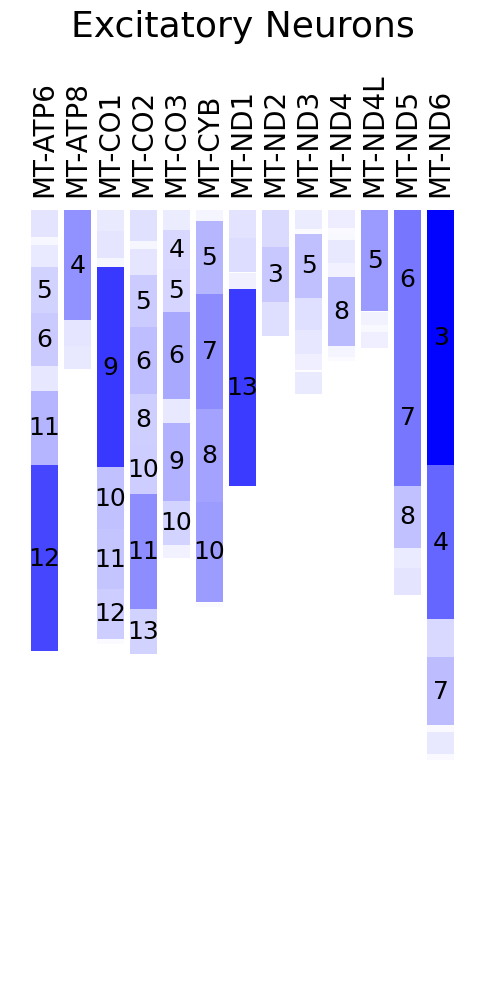

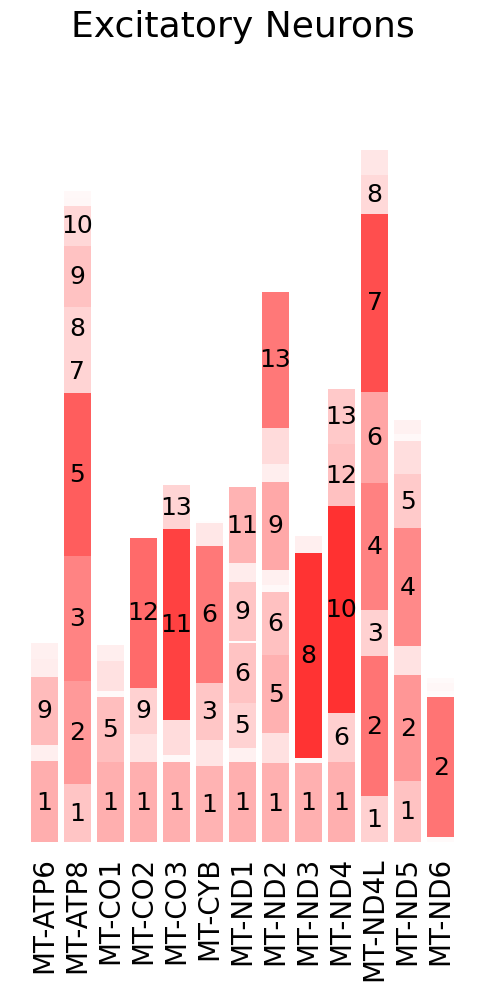

Oligodendrocytes


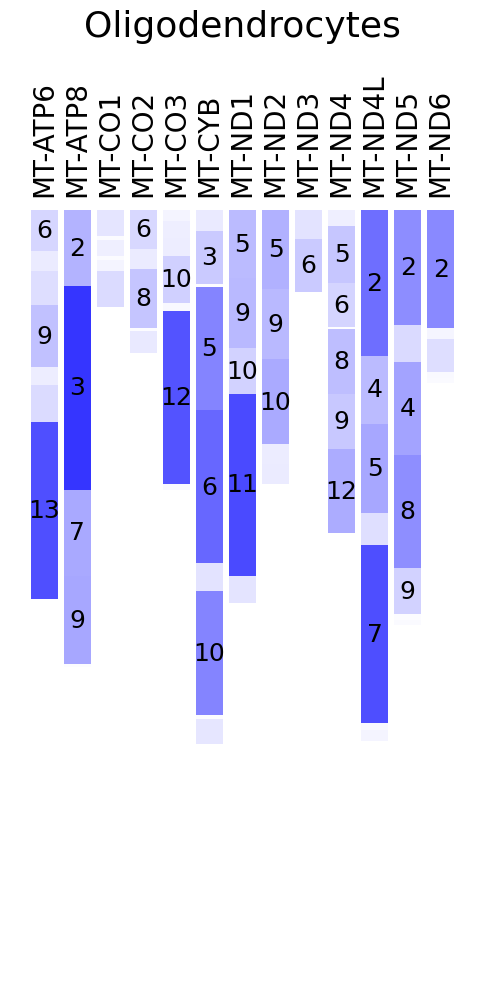

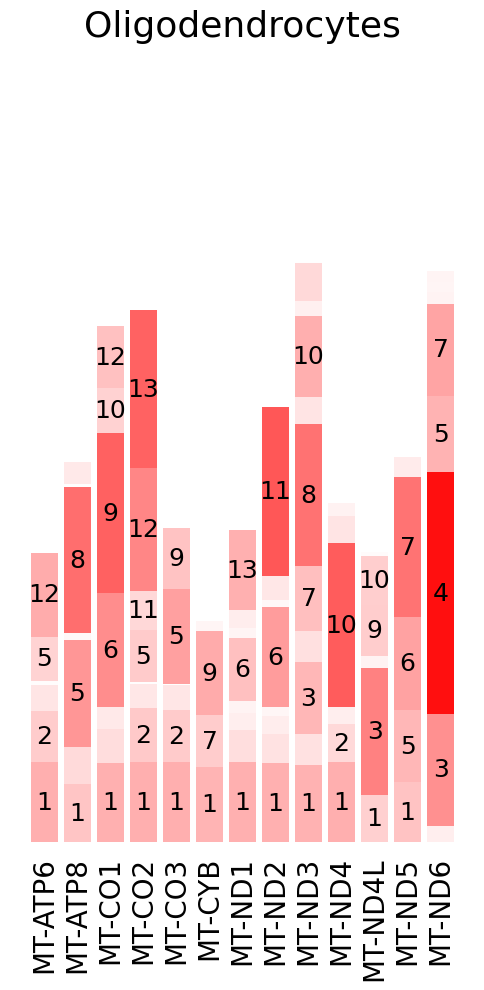

Inhibitory Neurons


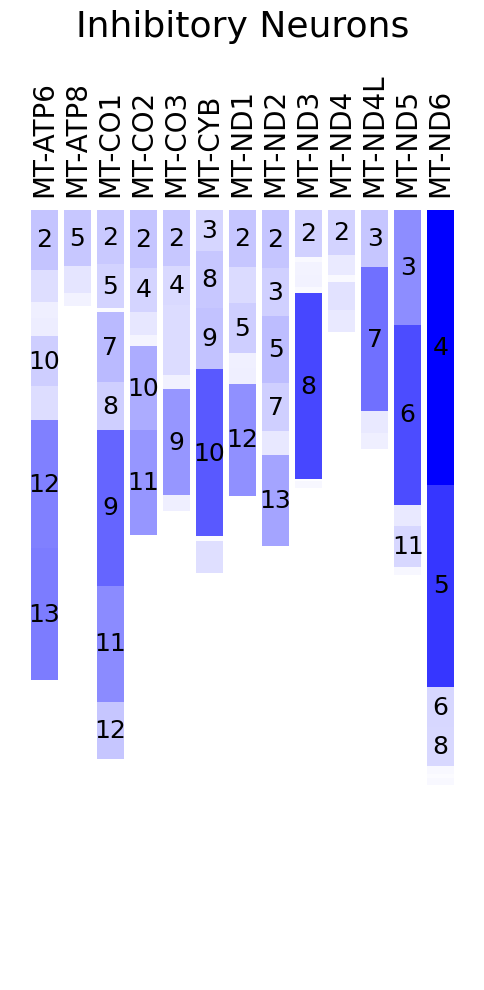

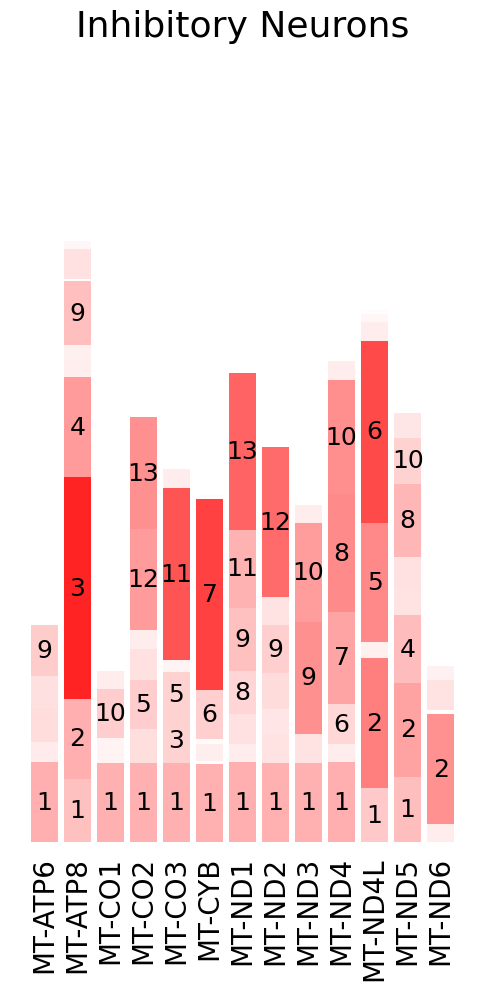

Astrocyte


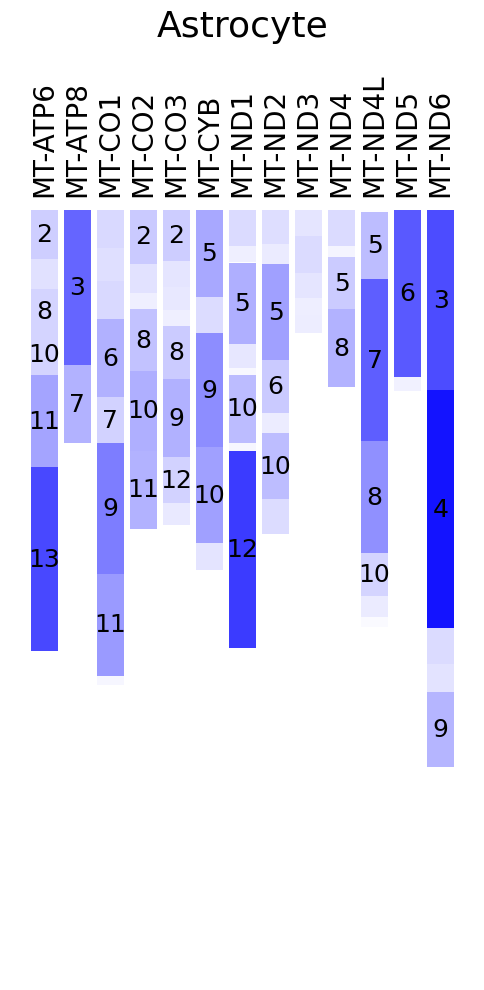

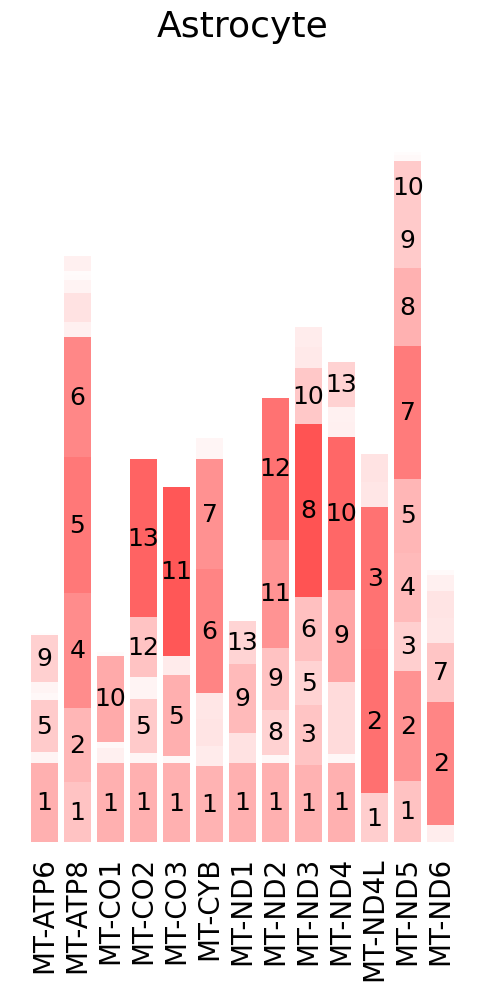

Microglia


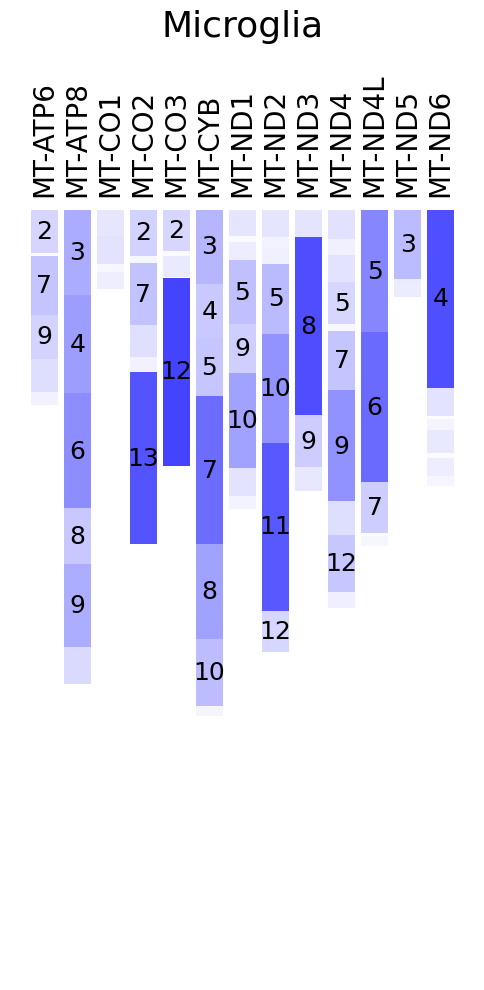

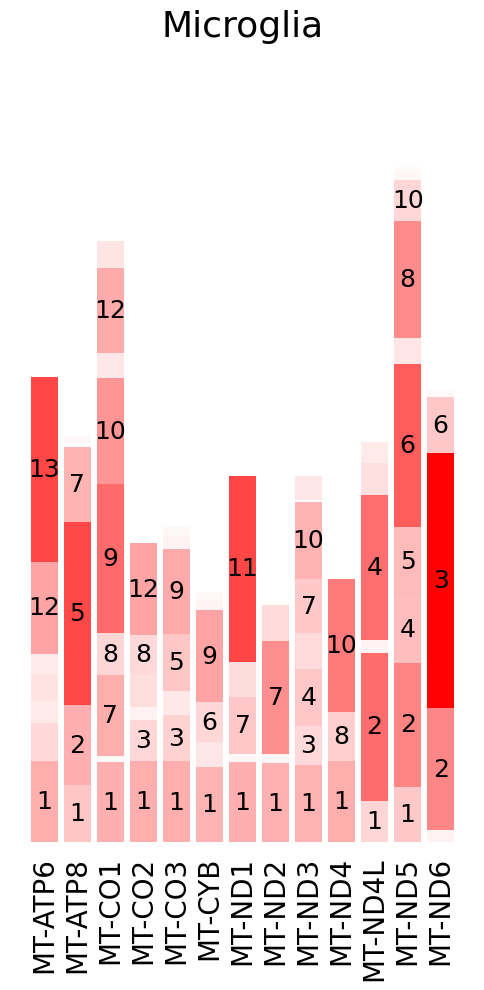

OPCs


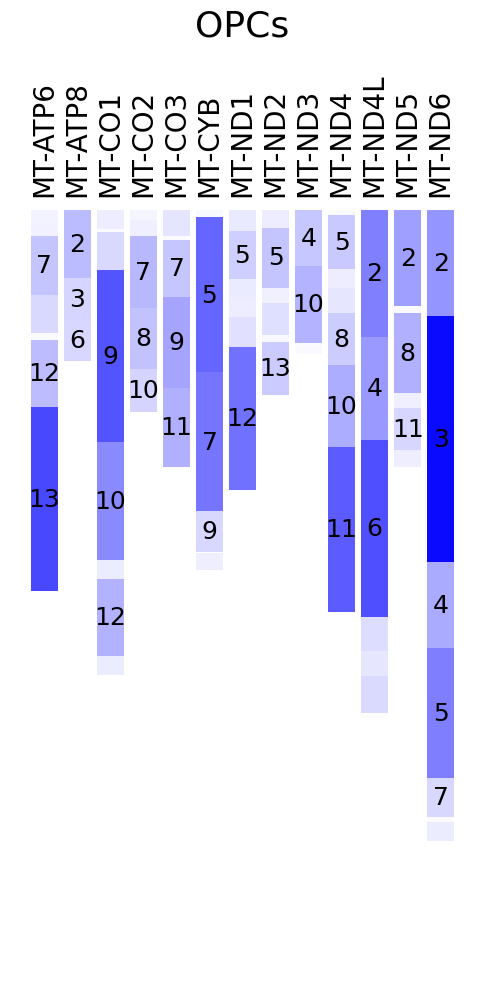

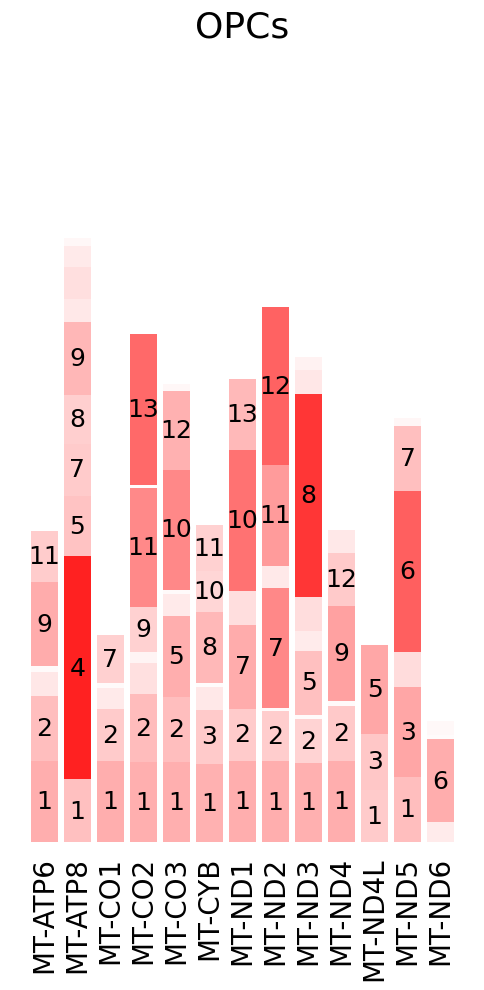

In [18]:
# ------------------------------ Main loop ------------------------------
date = '08.13.25'
for cell_type in cells_order[:6]:
    print(cell_type)
    pls = joblib.load(f"{date}/MT_PLS/pls_{cell_type}.gz")

    # Plot both positive and negative loadings
    plot_mt_loadings(pls, MT_genes, cell_type, positive=False)
    plot_mt_loadings(pls, MT_genes, cell_type, positive=True)

## Classification models

In [19]:
# === SETTINGS ===
date = '08.13.25'
auc_scores = []      # store AUC results across runs
cv_scores = []       # store CV scores across runs
pls_path = f'{date}/MT_PLS'
coefs_df = pd.DataFrame()
results = defaultdict(dict)  # nested dict: {cell_type: {sex: metrics}}

# === LOOP OVER CELL TYPES ===
for cell_type in cells_order[0:6]:
    print(cell_type)
    
    # Load PLS model and latent scores
    pls = joblib.load(f'{pls_path}/pls_{cell_type}.gz')
    nuc = np.load(f'{pls_path}/gen_exp_{cell_type}_nuc.npy')  # nuclear genes expression
    MT = np.load(f'{pls_path}/gen_exp_{cell_type}_MT.npy')    # mitochondrial genes expression
    x_scores, y_scores = pls.transform(nuc, MT)

    # Clinical metadata for individuals
    clin = pd.read_csv(f'{pls_path}/{cell_type}_clin_data.csv', index_col=0)
    idx_m = np.where(clin.msex == 1)
    idx_f = np.where(clin.msex == 0)
    sex = {'males': idx_m, 'females': idx_f}

    # === LOOP OVER SEX SUBGROUPS ===
    for sex_value, key in sex.items():
        print(sex_value)
        scores_dict = {}

        # Subset to sex group
        clin_sex = clin.iloc[key].reset_index()
        nuc = x_scores[key]
        MT = y_scores[key]

        # Exclude MCI/other dementia; keep AD vs controls
        mci_bool = ((clin_sex.cogdx_mci == 1) | (clin_sex.cogdx_other == 1)).ravel()
        y = clin_sex.cogdx_ad.loc[~mci_bool].reset_index(drop=True).ravel()
        nuc = nuc[~mci_bool]
        print(f'Percentage of cells coming from AD patients: {y.sum() / len(y):.2f}')

        # === CLASSIFICATION ACROSS COMPONENTS ===
        for comp in tqdm(range(0, 13)):
            x = np.array(nuc[:, comp]).reshape(-1, 1)
            clf = LogisticRegression(random_state=1, solver='newton-cholesky')
            k = 5
            cv = KFold(n_splits=k, shuffle=True, random_state=1)

            score, roc_auc = [], []
            for train_index, test_index in cv.split(x):
                clf.fit(x[train_index], y[train_index])
                score.append(clf.score(x[test_index], y[test_index]))
                roc_auc.append(roc_auc_score(y, clf.predict_proba(x)[:, 1]))

            # Aggregate metrics
            cv_score = np.mean(score)
            std_auc = np.std(roc_auc)
            mean_auc = np.mean(roc_auc)

            # Store results for this component
            new_key = f'{cell_type}_{comp + 1}'
            scores_dict[new_key] = {
                'auc': mean_auc,
                'std': std_auc,
                'cv': cv_score,
                'coefs': clf.fit(x, y).coef_.ravel()
            }

            # Save trained model
            joblib.dump(clf, f'{date}/AD_classification/{sex_value}/model_1_{cell_type}_{comp + 1}.gz')

        # Collect odds ratios and AUCs across all components
        coefs_list = [v['coefs'] for v in scores_dict.values()]
        auc_list = [v['auc'] for v in scores_dict.values()]
        sex_odds = np.exp(np.array(coefs_list))  # odds ratios from coefficients
        sex_auc = np.array(auc_list).reshape(-1, 1)

        # Store results for later
        results[cell_type][sex_value] = {
            'odds': sex_odds.tolist(), # convert numpy arrays to list to save to json
            'auc': sex_auc.tolist() # convert numpy arrays to list to save to json
        }


Excitatory Neurons
males
Percentage of cells coming from AD patients: 0.47


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


females
Percentage of cells coming from AD patients: 0.53


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Oligodendrocytes
males
Percentage of cells coming from AD patients: 0.49


100%|██████████| 13/13 [00:02<00:00,  5.95it/s]


females
Percentage of cells coming from AD patients: 0.54


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Inhibitory Neurons
males
Percentage of cells coming from AD patients: 0.46


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


females
Percentage of cells coming from AD patients: 0.52


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Astrocyte
males
Percentage of cells coming from AD patients: 0.47


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


females
Percentage of cells coming from AD patients: 0.54


100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


Microglia
males
Percentage of cells coming from AD patients: 0.45


100%|██████████| 13/13 [00:00<00:00, 20.34it/s]


females
Percentage of cells coming from AD patients: 0.56


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


OPCs
males
Percentage of cells coming from AD patients: 0.45


100%|██████████| 13/13 [00:00<00:00, 18.36it/s]


females
Percentage of cells coming from AD patients: 0.53


100%|██████████| 13/13 [00:00<00:00, 14.87it/s]


In [20]:
# Specify file name and path
filename = "material/MT_PLS/AD_classification/AD_classification_results.json"

# Save dictionary as json file
with open(filename, 'w') as f:
    json.dump(results, f, indent=4) # human-readable

In [21]:
# === PLOTTING FUNCTION ===
def plot_sex_results(odds, auc, ax_odds, ax_auc, label, title=None):
    """
    Plot two side-by-side heatmaps:
      1. Odds ratios across components (odds heatmap).
      2. AUC values for classification performance (AUC heatmap).

    Parameters
    ----------
    odds : array-like
        Odds ratios (components x labels).
    auc : array-like
        AUC values (components x 1).
    ax_odds : matplotlib Axes
        Axis on which to plot the odds heatmap.
    ax_auc : matplotlib Axes
        Axis on which to plot the AUC heatmap.
    label : list of str
        Labels for x-axis of odds heatmap.
    title : str, optional
        Title for the odds heatmap.
    """

    # --- Odds heatmap (left panel) ---
    sns.heatmap(
        odds,
        square=True,
        xticklabels=label,
        yticklabels=range(1, 14),
        cmap=plt.cm.RdBu_r,
        vmin=0.80, vmax=1.20, # Symmetric around 1 (neutral odds ratio)
        cbar=False,
        ax=ax_odds
    )
    ax_odds.tick_params(labelsize=8)
    if title:
        ax_odds.set_title(title, fontsize=10, fontweight='bold', x=1)

    # --- AUC heatmap (right panel) ---
    sns.heatmap(
        auc,
        square=True,
        xticklabels=['AUC'],
        yticklabels=[],
        vmin=0.50, vmax=0.65, # Restrict scale to meaningful AUC range
        cmap='rocket_r',
        annot=True, # Show numeric values
        annot_kws={"fontsize": 8},
        cbar=False,
        ax=ax_auc
    )
    ax_auc.tick_params(labelsize=8)


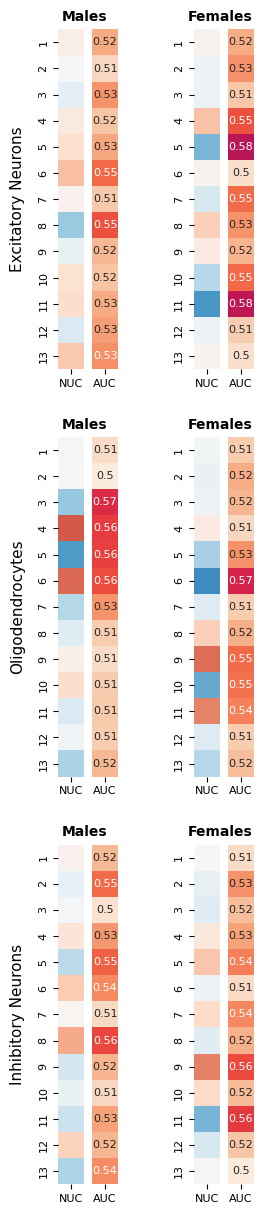

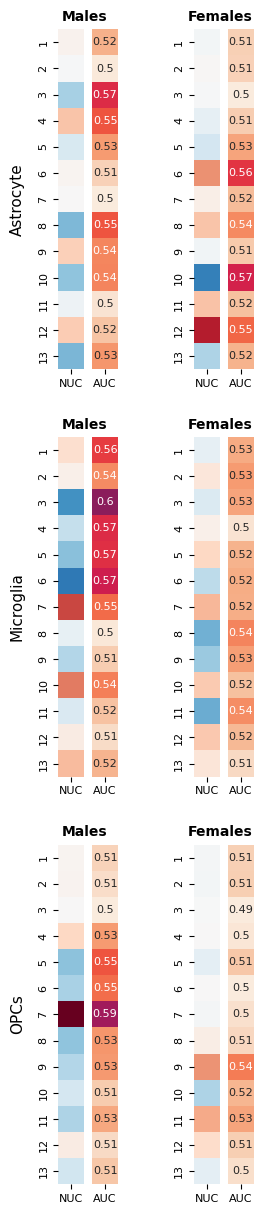

In [22]:
# === CREATE MULTI-PANEL FIGURES ===

# Convert results dict into a list of items for easier slicing
results_items = list(results.items())

# Plot in two groups to stack the columns and save space
panels = {
    "exc-oligo-inh": results_items[:3],   # first 3 cell types
    "astro-micro-opc": results_items[3:]   # last 3 cell types
}

for panel_name, panel_data in panels.items():
    n_celltypes = len(panel_data)

    # Create figure for this subset (3 cell types at the time)
    fig = plt.figure(figsize=(3.5, 6 * 2.5))
    gs = gridspec.GridSpec(
        nrows=n_celltypes, ncols=8,
        wspace=0.01, hspace=0.2
    )

    # Loop through cell types in this panel
    for i, (cell_type, sex_data) in enumerate(panel_data):
        
        # --- Male plots ---
        ax_odds_m = fig.add_subplot(gs[i, 0])  # Odds heatmap
        ax_auc_m = fig.add_subplot(gs[i, 1])   # AUC heatmap
        
        plot_sex_results(
            odds=sex_data['males']['odds'],
            auc=sex_data['males']['auc'],
            ax_odds=ax_odds_m,
            ax_auc=ax_auc_m,
            label=['NUC'],
            title='Males'
        )
        
        # --- Female plots ---
        ax_odds_f = fig.add_subplot(gs[i, 4])  # Odds heatmap
        ax_auc_f = fig.add_subplot(gs[i, 5])   # AUC heatmap
        
        plot_sex_results(
            odds=sex_data['females']['odds'],
            auc=sex_data['females']['auc'],
            ax_odds=ax_odds_f,
            ax_auc=ax_auc_f,
            label=['NUC'],
            title='Females'
        )
        
        # Add cell type label on left side of male panel
        ax_odds_m.set_ylabel(
            cell_type, fontsize=11, rotation=90,
            labelpad=15, va='center'
        )

    # Save each figure separately
    plt.savefig(
        f'material/MT_PLS/AD_classification/{panel_name}_CELLTYPES_PANEL.png',
        dpi=300, bbox_inches='tight'
    )
    plt.show()


## GSEA

In [23]:
date = '08.13.25'

In [24]:
def gsea2(pathh,loadings,gene_list,comp,pval,atlas,save=True):

    """
    Perform Gene Set Enrichment Analysis (GSEA) on a single PLS component
    using GO Biological Process pathways.

    Args:
        pathh (str): Directory path for saving results if save=True.
        pls: Fitted PLSRegression object with attribute x_loadings_.
        gene_list (list): List of genes corresponding to the PLS loadings.
        comp (int): Index of the PLS component to analyze.
        pval (float): FDR threshold for significant pathways.
        save (bool, optional): Whether to save results to a text file.

    Returns:
        pd.DataFrame: DataFrame of significant GSEA pathways for the given component.
    """

    # Perform preranked GSEA using gene weights (PLS loadings)
    nz_res = gp.prerank(
        rnk=pd.DataFrame({'genes': gene_list, 'PLS_weights': loading}),
        gene_sets= atlas,                         # Define reference annotations
        min_size=5,                               # Minimum gene set size
        max_size=len(gene_list),                  # Maximum gene set size
        outdir=None,                              # Do not save default GSEA output
        permutation_num=1000,                     # Number of permutations for significance
        seed=42,                                  # Reproducibility
        verbose=False
    )

    # Extract results as a DataFrame
    nz_gsea_df = nz_res.res2d

    # Order pathways by enrichment score (ES)
    nz_gsea_df = nz_gsea_df.sort_values(by='ES')

    # Filter pathways that pass the FDR threshold
    nz_gsea_df_sig = nz_gsea_df[nz_gsea_df["FDR q-val"] < pval].reset_index(drop=True)

    # Optionally append results to a text file
    if save:
        with open(f'{pathh}/gsea_{cell_type}_{pval}.txt', 'a') as f:
            f.write(f'PLS-C {comp+1} \n')
            f.write(f'Number of significantly enriched pathways: {nz_gsea_df_sig.Term.values.shape[0]} \n')
            f.write('Pathways \n')
            f.write(f'{nz_gsea_df_sig.Term.values} \n')
            f.write('\n')

    # Return significant pathways
    return nz_gsea_df_sig

In [25]:
def summarize_paths(nz_gsea_df_sig, comp):
    """
    Summarize significant GSEA pathways for a given PLS component by grouping related terms.

    Args:
        nz_gsea_df_sig (pd.DataFrame): Significant pathways from GSEA with a 'Term' column.
        comp (int): Index of the PLS component (used for naming the output column).

    Returns:
        pd.DataFrame: A single-row DataFrame with grouped pathway terms for the component.
    """

    df = pd.DataFrame()  # Initialize empty DataFrame for output
    paths = []           # List to store grouped pathways

    # Loop over all significant GSEA hits
    for hits in range(len(nz_gsea_df_sig)):
        grp = []  # Temporary list to store a group of related pathways

        # Extract the last word of the GO term (used for initial grouping)
        go_1 = nz_gsea_df_sig.Term[hits].split(' ')[-1]

        # Skip if this term is already included in previous groups
        if go_1 in " ".join(str(element) for element in paths):
            continue

        # Add the current term to the group
        grp.append(nz_gsea_df_sig.Term[hits])

        # Compare with subsequent terms to find similar/related pathways
        for counter in range(1, len(nz_gsea_df_sig) - hits):
            go_2 = nz_gsea_df_sig.Term[hits + counter].split(' ')[-1]

            # Skip if this term is already included in previous groups
            if go_2 in " ".join(str(element) for element in paths):
                continue

            # Group terms with overlapping names (ignoring last 2 characters)
            elif go_1[:-2] == go_2[:-2]:
                grp.append(nz_gsea_df_sig.Term[hits + counter])

        # Add the grouped pathways to the main list
        paths.append(grp)

    # Clean and format grouped pathways into strings
    paths_list = []
    for path in paths:
        str_path = "; ".join(str(element) for element in path)  # Join group with '; '
        str_path = re.sub(r'\d+', '', str_path)                # Remove digits
        str_path = re.sub('[()]', '', str_path)                # Remove parentheses
        str_path = re.sub(':', '', str_path)                   # Remove colons
        paths_list.append(str_path)

    # Store the result in a DataFrame with component-specific column name
    df[f'comp_{comp+1}'] = paths_list
    df = df.T  # Transpose so that component is the row

    return df

In [26]:
pval = 0.05
go_atlases = {
    "GO_Biological": "GO_Biological_Process_2023",
    "GO_Cellular": "GO_Cellular_Component_2023",
    "GO_Molecular": "GO_Molecular_Function_2023"
}

def run_gsea_for_celltype(cell_type, new_path, atlas, pval=0.05):
    """
    Run GSEA for a given cell type and GO atlas across all PLS components.
    Saves results per component and a summary file per cell type.
    """
    print(cell_type)
    pls = joblib.load(f'{date}/MT_PLS/pls_{cell_type}.gz')
    genes = nuc_genes

    # Get PLS loadings for nuclear genes
    loadings_df = pd.DataFrame(pls.x_loadings_, index=genes)

    # Collect pathways across components
    cell_type_paths_df = pd.DataFrame()
    for comp in tqdm(range(13), desc=f"{cell_type} comps"):
        comp_loadings = loadings_df.iloc[:, comp].to_numpy()
        
        # Run GSEA
        nz_gsea_df_sig = gsea2(new_path, comp_loadings, genes, comp, pval, atlas, save=True)
        nz_gsea_df_sig.to_csv(f'{new_path}/{cell_type}_comp_{comp+1}_hits.csv')

        # Summarize and append
        comp_df = summarize_paths(nz_gsea_df_sig, comp)
        cell_type_paths_df = pd.concat([cell_type_paths_df, comp_df], axis=0)

    # Save summary per cell type
    cell_type_paths_df.to_csv(f'{new_path}/{cell_type}_hits.csv')

In [27]:
# === Loop over atlases ===
# for folder, atlas in go_atlases.items():
#     new_path = f'{date}/MT_PLS/{folder}'
#     print(f"\nRunning analysis for {atlas} -> {new_path}")

#     for cell_type in cells_order[:6]:
#         run_gsea_for_celltype(cell_type, new_path, atlas, pval=pval)

In [28]:
def collect_gsea_hits(date, cells_order, ontology, max_comp=13, pval=0.05, outdir="github"):
    """
    Collects GSEA significant terms across all cell types and components 
    for a given ontology and saves a combined CSV.

    Parameters
    ----------
    date : str
        Date string used in path.
    cells_order : list
        List of cell types to process.
    ontology : str
        One of 'GO_Biological_Process_2023', 
               'GO_Molecular_Function_2023',
               'GO_Cellular_Component_2023'.
    max_comp : int
        Number of components (default 13).
    pval : float
        FDR threshold (default 0.05).
    outdir : str
        Output folder for combined CSV (default "github").
    """

    # Build input/output paths
    go_atlases = {
    "GO_Biological_Process_2023": "GO_Biological",
    "GO_Cellular_Component_2023": "GO_Cellular",
    "GO_Molecular_Function_2023": "GO_Molecular"
    }
    short_name = go_atlases[ontology]
    new_path = f"{date}/MT_PLS/{short_name}"
    outfile = f"material/supplementary_tables/GSEA_{short_name}.csv"

    hits_list = []

    for cell_type in cells_order[:6]:
        pls = joblib.load(f"{date}/MT_PLS/pls_{cell_type}.gz")

        for comp in range(max_comp):
            comp_file = f"{new_path}/{cell_type}_comp_{comp+1}_hits.csv"
            nz_gsea_df_sig = pd.read_csv(comp_file, index_col=0)
            nz_gsea_df_sig = nz_gsea_df_sig.loc[nz_gsea_df_sig["FDR q-val"] < pval]

            if not nz_gsea_df_sig.empty:
                nz_gsea_df_sig["cell_type"] = cell_type
                nz_gsea_df_sig["comp"] = comp + 1
                hits_list.append(nz_gsea_df_sig)

    # Concatenate and save
    if hits_list:
        (
            pd.concat(hits_list, axis=0)
              .reset_index(drop=True)
              .set_index(["cell_type", "comp"])
              .to_csv(outfile)
        )
        print(f"Saved {outfile}")
    else:
        print(f"No significant hits for {ontology}")

In [29]:
# === Save signifciant hits (FDR q-val<0.05) into tables to include in the Supplementary Information  ===
ontologies = [
    "GO_Biological_Process_2023",
    "GO_Molecular_Function_2023",
]

for ont in ontologies:
    collect_gsea_hits(date, cells_order, ont)

Saved material/supplementary_tables/GSEA_GO_Biological.csv
Saved material/supplementary_tables/GSEA_GO_Molecular.csv


#### Zoom in 

In [30]:
def heatmap(x, y, **kwargs):

    """
    Creates a scatter-based heatmap with optional color and size mapping, including legends.

    Parameters
    ----------
    x : list or array-like
        Categories or coordinates along the x-axis.
    y : list or array-like
        Categories or coordinates along the y-axis.
    **kwargs : dict
        Optional keyword arguments:
        - color : list or array-like
            Values mapped to colors of the points.
        - palette : list
            Color palette used for mapping values to colors.
        - color_range : tuple
            (center, min, max) range of values mapped to colors.
        - size : list or array-like
            Values mapped to sizes of the points.
        - size_range : tuple
            (min, max) range of values mapped to point sizes.
        - size_scale : float
            Scaling factor for point sizes.
        - x_order : list
            Custom order of x categories.
        - y_order : list
            Custom order of y categories.
        - xlabel, ylabel : str
            Axis labels.
        - x_tick_rotation, y_tick_rotation : int
            Rotation of tick labels.
        - fontsize : int
            Font size for tick labels.
        - num_size_label : int
            Number of labels shown on the size legend.
        - size_labels : list
            Custom size labels for the size legend.
        - facecolor : str
            Background color of the heatmap.
        - marker : str
            Marker style for points.
        - m_color : str
            Color of points in the size legend.
        - Additional plotting arguments are passed to matplotlib.scatter.

    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes of the main heatmap plot.
    ax1 : matplotlib.axes.Axes
        Axes of the color legend.
    ax2 : matplotlib.axes.Axes
        Axes of the size legend.
    size_labels : list
        Numeric labels used for the size legend.

    Notes
    -----
    - Both color and size can be used to encode values in the heatmap.
    - Includes automatic legends for color and size.
    - Handles categorical or numeric axes and allows custom ordering.
    """


    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_center, color_min, color_max = kwargs['color_range']
    else:
        color_center, color_min, color_max = np.mean(color), min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    x_rot = kwargs.get('x_tick_rotation', 45)
    y_rot = kwargs.get('y_tick_rotation', 0)
    fontsize = kwargs.get('fontsize', 14)
    num_size_label = kwargs.get('num_size_label', 4)
    size_labels = kwargs.get('size_labels', [])
    facecolor = kwargs.get('facecolor', '#FFFFFF')

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val, size_scale = size_scale):
        if val==-1:
            return 0
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in set([v for v in x])]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in set([v for v in y])]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 16, hspace=1, wspace=1.2) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-2]) # Use the left 14/16ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', \
         'marker', 'x_order', 'y_order', 'xlabel', 'ylabel', 'x_tick_rotation', \
         'y_tick_rotation','fontsize', 'num_size_label','m_color', 'size_labels', 'facecolor'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=x_rot, horizontalalignment='right', fontsize=fontsize)
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num], rotation=y_rot, fontsize = fontsize)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor(facecolor) #palette[len(palette)//2]) #'#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=fontsize)
    ax.set_ylabel(kwargs.get('ylabel', ''), fontsize=fontsize)

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax1 = plt.subplot(plot_grid[:,-2]) # Use the rightmost-1 column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax1.barh(
            y=bar_y,
            width=[1.33]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0,
        )
        ax1.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax1.grid(False) # Hide grid
        ax1.set_xticks([]) # Remove horizontal ticks
        ax1.set_yticks(np.linspace(min(bar_y), max(bar_y), 5)) # Show vertical ticks for min, middle and max
        ax1.yaxis.tick_left() # Show vertical ticks on the right
        # ax1.bar_label('NES')
        #ax1.set_axis_off()
        
    for spine in ax1.spines.values():
        spine.set_visible(False)

    # Plot the size reference
    ax2 = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot 
    # print(y_len)
    # print(y_to_num)
    size_labels = size_labels if size_labels else np.linspace(min(size), max(size), num_size_label).tolist()
    y_len = len(size_labels)
    ss = size_labels + [-1]*(y_len-len(size_labels))
    print(ss)
    print([value_to_size(v, size_scale=size_scale) for v in ss])
    ax2.scatter(
        x=[2]*y_len,
        y=np.arange(0,y_len),
        marker=marker,
        s=[value_to_size(v, size_scale=size_scale) for v in ss],
        c=kwargs.get('m_color','black'),
        **kwargs_pass_on
    )
    ax2.grid(False) # Hide grid
    ax2.set_facecolor('white')
    ax2.set_xticks([])
    # ax2.set_yticks([v for k,v in range(0,size_labels)][:len(size_labels)])

    ax2.yaxis.tick_right()

    ax2.patch.set_visible(False) 
    for spine in ax2.spines.values():
        spine.set_visible(False)

    return ax, ax1, ax2, size_labels


In [31]:
date = '08.13.25'
print(date)

08.13.25


In [32]:
def collect_hits(date, cells_order, ontology, keyword, max_comp=13, pval=0.05):
    """
    Collect keyword-enriched GSEA results for each cell type and component,
    producing two DataFrames:
      - NES masked by FDR
      - FDR masked by threshold

    Parameters
    ----------
    date : str
        Date string used in paths.
    cells_order : list
        List of cell types to process.
    ontology : str
        One of 'GO_Biological', 'GO_Molecular', 'GO_Cellular'.
    keyword : str
        Keyword to search in 'Term'.
    max_comp : int
        Number of components to iterate over.
    pval : float
        FDR significance threshold.

    Returns
    -------
    results_df : pd.DataFrame
        Pivot table of NES values masked by FDR.
    pval_df : pd.DataFrame
        Pivot table of FDR values masked by threshold.
    """
    go_atlases = {
    "GO_Biological_Process_2023": "GO_Biological",
    "GO_Cellular_Component_2023": "GO_Cellular",
    "GO_Molecular_Function_2023": "GO_Molecular"
    }
    short_name = go_atlases[ontology]
    new_path = f"{date}/MT_PLS/{short_name}"
    results_df = pd.DataFrame()
    pval_df = pd.DataFrame()

    for cell_type in cells_order[:6]:
        cell_results = []
        cell_pvals = []

        for comp in range(max_comp):
            comp_file = f"{new_path}/{cell_type}_comp_{comp+1}_hits.csv"
            df = pd.read_csv(comp_file, index_col=0)

            # Filter by keyword
            df = df[df["Term"].str.contains(keyword, case=False, na=False)].copy()
            if df.empty:
                continue

            df["abs_NES"] = df["NES"].abs()
            df["iddx"] = comp + 1

            # NES masked by FDR
            df["sig_NES"] = df["NES"].mask(df["FDR q-val"] > pval)
            # FDR masked by threshold
            df["sig_FDR"] = df["FDR q-val"].mask(df["FDR q-val"] > pval)

            cell_results.append(df[["Term", "sig_NES", "iddx"]])
            cell_pvals.append(df[["Term", "sig_FDR", "iddx"]])

        if cell_results:
            df_results = pd.concat(cell_results)
            df_results.index = f"{cell_type}_" + df_results.index.astype(str)
            pivot_results = df_results.pivot_table(
                index="Term", columns="iddx", values="sig_NES", aggfunc="first"
            )
            results_df = pd.concat([results_df, pivot_results], axis=1)

        if cell_pvals:
            df_pvals = pd.concat(cell_pvals)
            df_pvals.index = f"{cell_type}_" + df_pvals.index.astype(str)
            pivot_pvals = df_pvals.pivot_table(
                index="Term", columns="iddx", values="sig_FDR", aggfunc="first"
            )
            pval_df = pd.concat([pval_df, pivot_pvals], axis=1)

    return results_df, pval_df

In [33]:
def collect_hits(date, cells_order, ontology, keyword, max_comp=13, pval=0.05):
    """
    Collect keyword-enriched GSEA results for each cell type and component,
    producing two DataFrames (like your original workflow):
      - one_df: NES masked by FDR
      - pval_df: FDR masked by threshold

    Keeps the original column structure with 'iddx' as columns.
    """
    go_atlases = {
    "GO_Biological_Process_2023": "GO_Biological",
    "GO_Cellular_Component_2023": "GO_Cellular",
    "GO_Molecular_Function_2023": "GO_Molecular"
    }
    short_name = go_atlases[ontology]
    new_path = f"{date}/MT_PLS/{short_name}"
    cell_df_nes = pd.DataFrame() # normaliized enrichment score (NES)
    cell_df_pval = pd.DataFrame() # FDR q-val

    for cell_type in cells_order[:6]:

        cell_df = pd.DataFrame()
        for comp in range(max_comp):
            comp_file = f"{new_path}/{cell_type}_comp_{comp+1}_hits.csv"
            df = pd.read_csv(comp_file, index_col=0)
            # Filter by keyword
            df = df[df["Term"].str.contains(keyword, case=False, na=False)].copy()
            if df.empty:
                continue
            df["abs_NES"] = df["NES"].abs()
            df['comp'] = f'comp_{comp+1}'
            df = df.sort_values(by="abs_NES", ascending=False) # Sort by enrichment score 
            df["iddx"] = f"{cell_type}_" + f"{comp+1}"
            # df= df.set_index('iddx')
            df = df.mask(df["FDR q-val"] > pval) # Only keep significant values
            cell_df = pd.concat([cell_df, df])

        # Dataframe with the normaliized enrichment score (NES)
        df_nes = cell_df[["Term", "NES", "iddx"]]
        df_nes.index = f"{cell_type}_" + df_nes.index.astype(str) # Store cell type and component number for reference
        # df_nes["iddx"] = list(df_nes.index)
        df_nes = df_nes.reset_index().reset_index()
        pivot_nes = df_nes.pivot_table(index="Term", columns="iddx", values="NES", aggfunc="first")
        cell_df_nes = pd.concat([cell_df_nes, pivot_nes], axis=1) # Merge across cell types

        # Dataframe with the FDR q-val 
        df_pval = cell_df[["Term", "FDR q-val", "iddx"]]
        df_pval.index = f"{cell_type}_" + df_pval.index.astype(str) # Store cell type and component number for reference
        # df_pval["iddx"] = list(df_pval.index)
        df_pval = df_pval.reset_index().reset_index()
        pivot_pval = df_pval.pivot_table(index="Term", columns="iddx", values="FDR q-val", aggfunc="first")
        cell_df_pval = pd.concat([cell_df_pval, pivot_pval], axis=1) # Merge across cell types

    return cell_df_nes.sort_index(), cell_df_pval.sort_index()

In [34]:
# Collecting ubiquitin enrichment
results_df, pval_df = collect_hits(date, cells_order, "GO_Molecular_Function_2023", "ubiquitin")

In [35]:
# Manually order the columns with significant hits
col_ordered = [
      'Excitatory Neurons_1', 'Excitatory Neurons_2', 'Excitatory Neurons_3','Excitatory Neurons_5',
       'Oligodendrocytes_2', 'Oligodendrocytes_9', 'Oligodendrocytes_10', 'Oligodendrocytes_11', 'Oligodendrocytes_12',
       'Inhibitory Neurons_1', 'Inhibitory Neurons_2', 'Inhibitory Neurons_3',
       'Astrocyte_2', 'Astrocyte_7', 'Astrocyte_8',
       'Microglia_2', 'Microglia_3', 'Microglia_4', 'Microglia_7', 'Microglia_10',
       'OPCs_1', 'OPCs_2', 'OPCs_5', 'OPCs_7', 'OPCs_11',
      ]

In [36]:
row_ordered = [
       'Ubiquitin Binding (GO:0043130)',
       'Ubiquitin-Like Protein Ligase Binding (GO:0044389)',
       'Ubiquitin Protein Ligase Binding (GO:0031625)',
       'Ubiquitin-Protein Transferase Inhibitor Activity (GO:0055105)',
       'Ubiquitin Ligase Inhibitor Activity (GO:1990948)',
       ]
row_ordered.reverse()

/tmp/ipykernel_1131270/3228494811.py:7: RuntimeWarning: divide by zero encountered in log10
  size = np.nan_to_num(-np.log10(pval_df.values.flatten()), nan=0, posinf=3)
/tmp/ipykernel_1131270/3228494811.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[0.0, 1.264988353915147, 2.529976707830294, 3.794965061745441]
[2.0, 68.0, 134.0, 200.0]


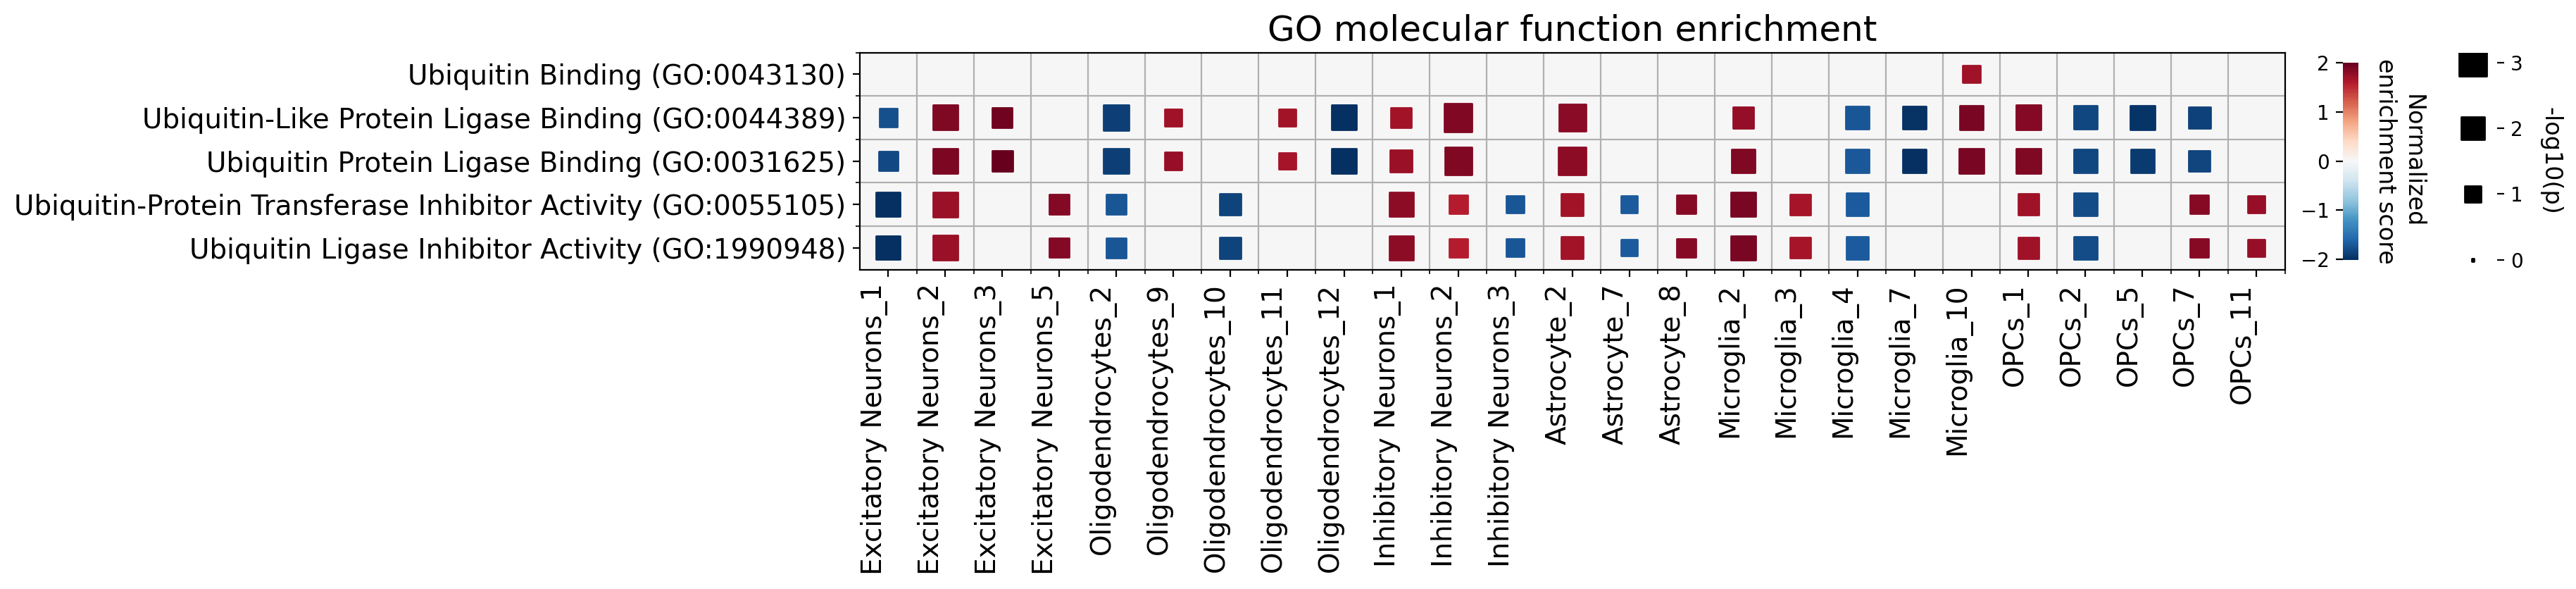

In [37]:
result_df = results_df[col_ordered]
pval_df = pval_df[col_ordered]

x = np.tile(result_df.columns, len(result_df.index))
y = np.repeat(result_df.index, len(result_df.columns))

size = np.nan_to_num(-np.log10(pval_df.values.flatten()), nan=0, posinf=3)

color = result_df.fillna(0).values.flatten()
palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]

f = plt.figure(figsize=(15, 2), dpi=200)

ax, ax1, ax2, ss = heatmap(
    x=x,
    y=y,
    x_order = col_ordered,
    y_order = row_ordered,
    size=size,             # inverse p-values
    size_scale=200,
    color=color,           # NES values
    color_range=(0, -2, 2),  # ✅ center=0, min=-2, max=2
    palette=palette,
    marker='s',
    fontsize=14,
    x_tick_rotation=90,
    num_size_label=4,
    m_color='black',
    # size_labels=[0,1,2,3]
)

cmap = plt.get_cmap("RdBu_r")
norm = mcolors.Normalize(vmin=-2, vmax=2)  # <-- use your actual NES range

# Get RGBA color for NES = 0
color_at_zero = cmap(norm(0))
ax.set_facecolor(color_at_zero) # Make background white

ax1.set_ylabel('Normalized\nenrichment score', fontsize=12, rotation=-90, labelpad=17)
ax1.yaxis.set_label_position("right")
ax2.set_ylabel('-log10(p)', rotation=270, fontsize=12, labelpad=20)
ax2.yaxis.set_label_position("right")
ax.set_title("GO molecular function enrichment", fontsize=18)
plt.tight_layout()


In [38]:
# Collecting p53 enrichment
results_df, pval_df = collect_hits(date, cells_order, "GO_Biological_Process_2023", "p53")

In [39]:
# manually order the columns
col_ordered = ['Excitatory Neurons_1', 'Excitatory Neurons_2', 'Excitatory Neurons_6',
       'Oligodendrocytes_2', 'Oligodendrocytes_7', 'Oligodendrocytes_10',
       'Inhibitory Neurons_1', 'Inhibitory Neurons_2', 'Inhibitory Neurons_5',
       'Astrocyte_2', 'Astrocyte_8',
       'Microglia_1', 'Microglia_2', 'Microglia_3', 'Microglia_4',
       'OPCs_1', 'OPCs_11', 'OPCs_2', 'OPCs_7']

[0.0, 1.1049127601565185, 2.209825520313037, 3.3147382804695553]
[4.0, 136.0, 268.0, 400.0]


/tmp/ipykernel_1131270/3241160508.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


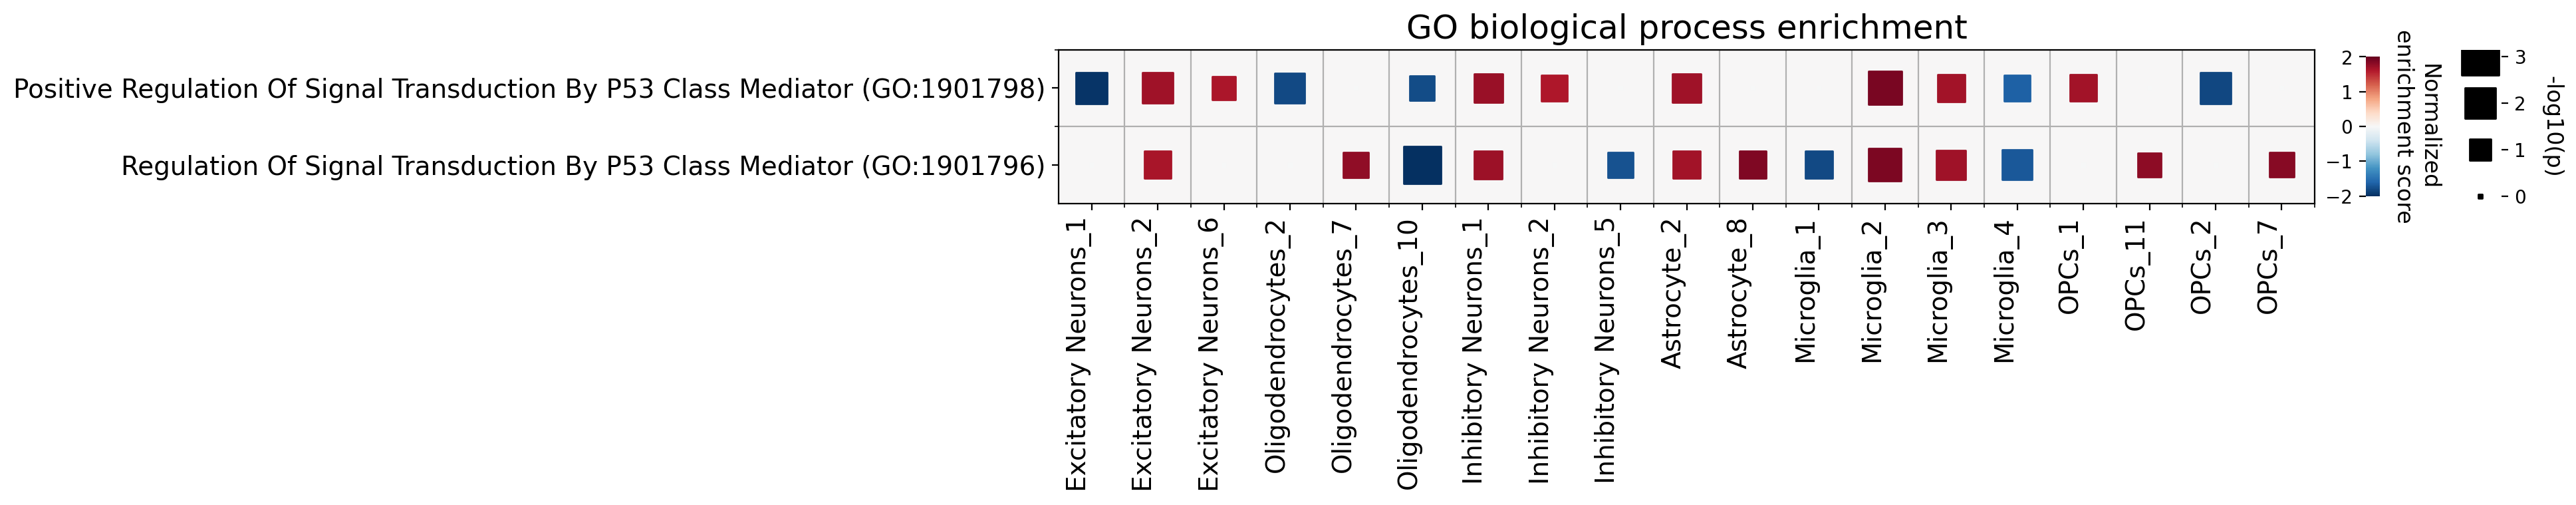

In [40]:
result_df = results_df[col_ordered]
pval_df = pval_df[col_ordered]

x = np.tile(result_df.columns, len(result_df.index))
y = np.repeat(result_df.index, len(result_df.columns))

size = np.nan_to_num(-np.log10(pval_df.values.flatten()), nan=0, posinf=3)

color = result_df.fillna(0).values.flatten()
palette = [plt.cm.get_cmap("RdBu_r")(i) for i in np.linspace(0, 1, 256)]

f = plt.figure(figsize=(14, 1.5), dpi=200)

ax, ax1, ax2, ss = heatmap(
    x=x,
    y=y,
    x_order = col_ordered,
    size=size,             # inverse p-values
    size_scale=400,
    color=color,           # NES values
    color_range=(0, -2, 2),  # ✅ center=0, min=-2, max=2
    palette=palette,
    marker='s',
    fontsize=14,
    x_tick_rotation=90,
    num_size_label=4,
    m_color='black',
    # size_labels=[0,1,2,3]
)

cmap = plt.get_cmap("RdBu_r")
norm = mcolors.Normalize(vmin=-2, vmax=2)  # <-- use your actual NES range

# Get RGBA color for NES = 0
color_at_zero = cmap(norm(0))
ax.set_facecolor(color_at_zero) # Make background white

ax1.set_ylabel('Normalized\nenrichment score', fontsize=12, rotation=-90, labelpad=17)
ax1.yaxis.set_label_position("right")
ax2.set_ylabel('-log10(p)', rotation=270, fontsize=12, labelpad=20)
ax2.yaxis.set_label_position("right")
ax.set_title("GO biological process enrichment", fontsize=18)
plt.tight_layout()


#### Network plots

In [41]:
# Classification results from previous step are stored in json format
filename = "material/MT_PLS/AD_classification/AD_classification_results.json"
with open(filename, 'r') as f:
    results = json.load(f)


In [42]:
print(date)

08.13.25


In [43]:
def plot_network(df_sig, cell_type, comp, color):

    nodes, edges = enrichment_map(df_sig, top_term=len(df_sig))

    # build graph
    G = nx.from_pandas_edgelist(edges,
                                source='src_idx',
                                target='targ_idx',
                                edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])
    G.add_nodes_from(nodes.index)

    fig, ax = plt.subplots(figsize=(15,15), dpi=200)
    fig.tight_layout()
    fig.subplots_adjust(right=1.2)

    # init node cooridnates
    pos=nx.layout.spiral_layout(G)
    # Draw node
    # Normalize NES values
    # Ensure NES is numeric
    nodes['NES'] = pd.to_numeric(nodes['NES'], errors='coerce')

    # Drop rows with invalid NES values (if any)
    nodes = nodes.dropna(subset=['NES'])

    nx.draw_networkx_nodes(G,
                        pos=pos,
                        edgecolors='#CDDBD4',
                        node_color = color,
                        # node_color='slateblue',
                        # node_color = 'palevioletred',
                        node_size=list(nodes.Hits_ratio *1000))

    # draw node label
    label_ratio = 1.0/25.0
    pos_labels = {} 
    #For each node in the Graph
    for aNode in G.nodes():
        #Get the node's position from the layout
        x,y = pos[aNode]
        #Get the node's neighbourhood
        N = G[aNode]
        #Find the centroid of the neighbourhood. The centroid is the average of the Neighbourhood's node's x and y coordinates respectively.
        #Please note: This could be optimised further
        cx = sum(map(lambda x:pos[x][0], N)) / len(pos)
        cy = sum(map(lambda x:pos[x][1], N)) / len(pos)
        #Get the centroid's 'direction' or 'slope'. That is, the direction TOWARDS the centroid FROM aNode.
        slopeY = abs(y-cy) * -1
        slopeX = abs(x-cx) * -1
        #Position the label at some distance along this line. Here, the label is positioned at about 1/8th of the distance.
        pos_labels[aNode] = (x+slopeX*label_ratio+0.03, y+slopeY*label_ratio-0.05)

    #Finally, redraw the labels at their new position.
    print(nodes.Term.to_dict())
    print(pos_labels)
    connected_nodes = [n for n in G.nodes if G.degree[n] > 0]
    nx.draw_networkx_labels(G,pos=pos_labels,font_size=10,labels= nodes.Term.to_dict(), horizontalalignment = 'left', verticalalignment= 'top')

    # draw edge
    edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
    nx.draw_networkx_edges(G,
                        pos=pos,
                        width=list(map(lambda x: x*10, edge_weight)),
                        edge_color='#CDDBD4')
    # plt.tight_layout()
    plt.margins(0.95)  # Add 20% margin around plot
    #plt.savefig(f'{date}/updated_plots/network_graph_{cell_type}_{comp}.svg', dpi=200, bbox_inches='tight')
    plt.show()
    plt.close('all')

[[0.54394898 0.11506307 0.35693521 1.        ]]
{0: 'Protein Serine/Threonine Kinase Activity (GO:0004674)', 1: "mRNA 5'-UTR Binding (GO:0048027)", 2: 'RNA Binding (GO:0003723)', 3: 'mRNA Binding (GO:0003729)', 4: 'Ubiquitin-Protein Transferase Inhibitor Activity (GO:0055105)', 5: 'rRNA Binding (GO:0019843)', 6: 'Ubiquitin Ligase Inhibitor Activity (GO:1990948)'}
{1: (-0.01011846362288498, -0.916926685853374), 2: (0.29052325074418095, -0.8024442671966491), 3: (0.4703775535447885, -0.48676004510578513), 4: (0.4591132750504566, -0.0572411190069183), 5: (0.2114583441461538, 0.35088244306038546), 6: (-0.3076712493668735, 0.6488962670825843), 0: (-1.01, 0.7372794139753859)}


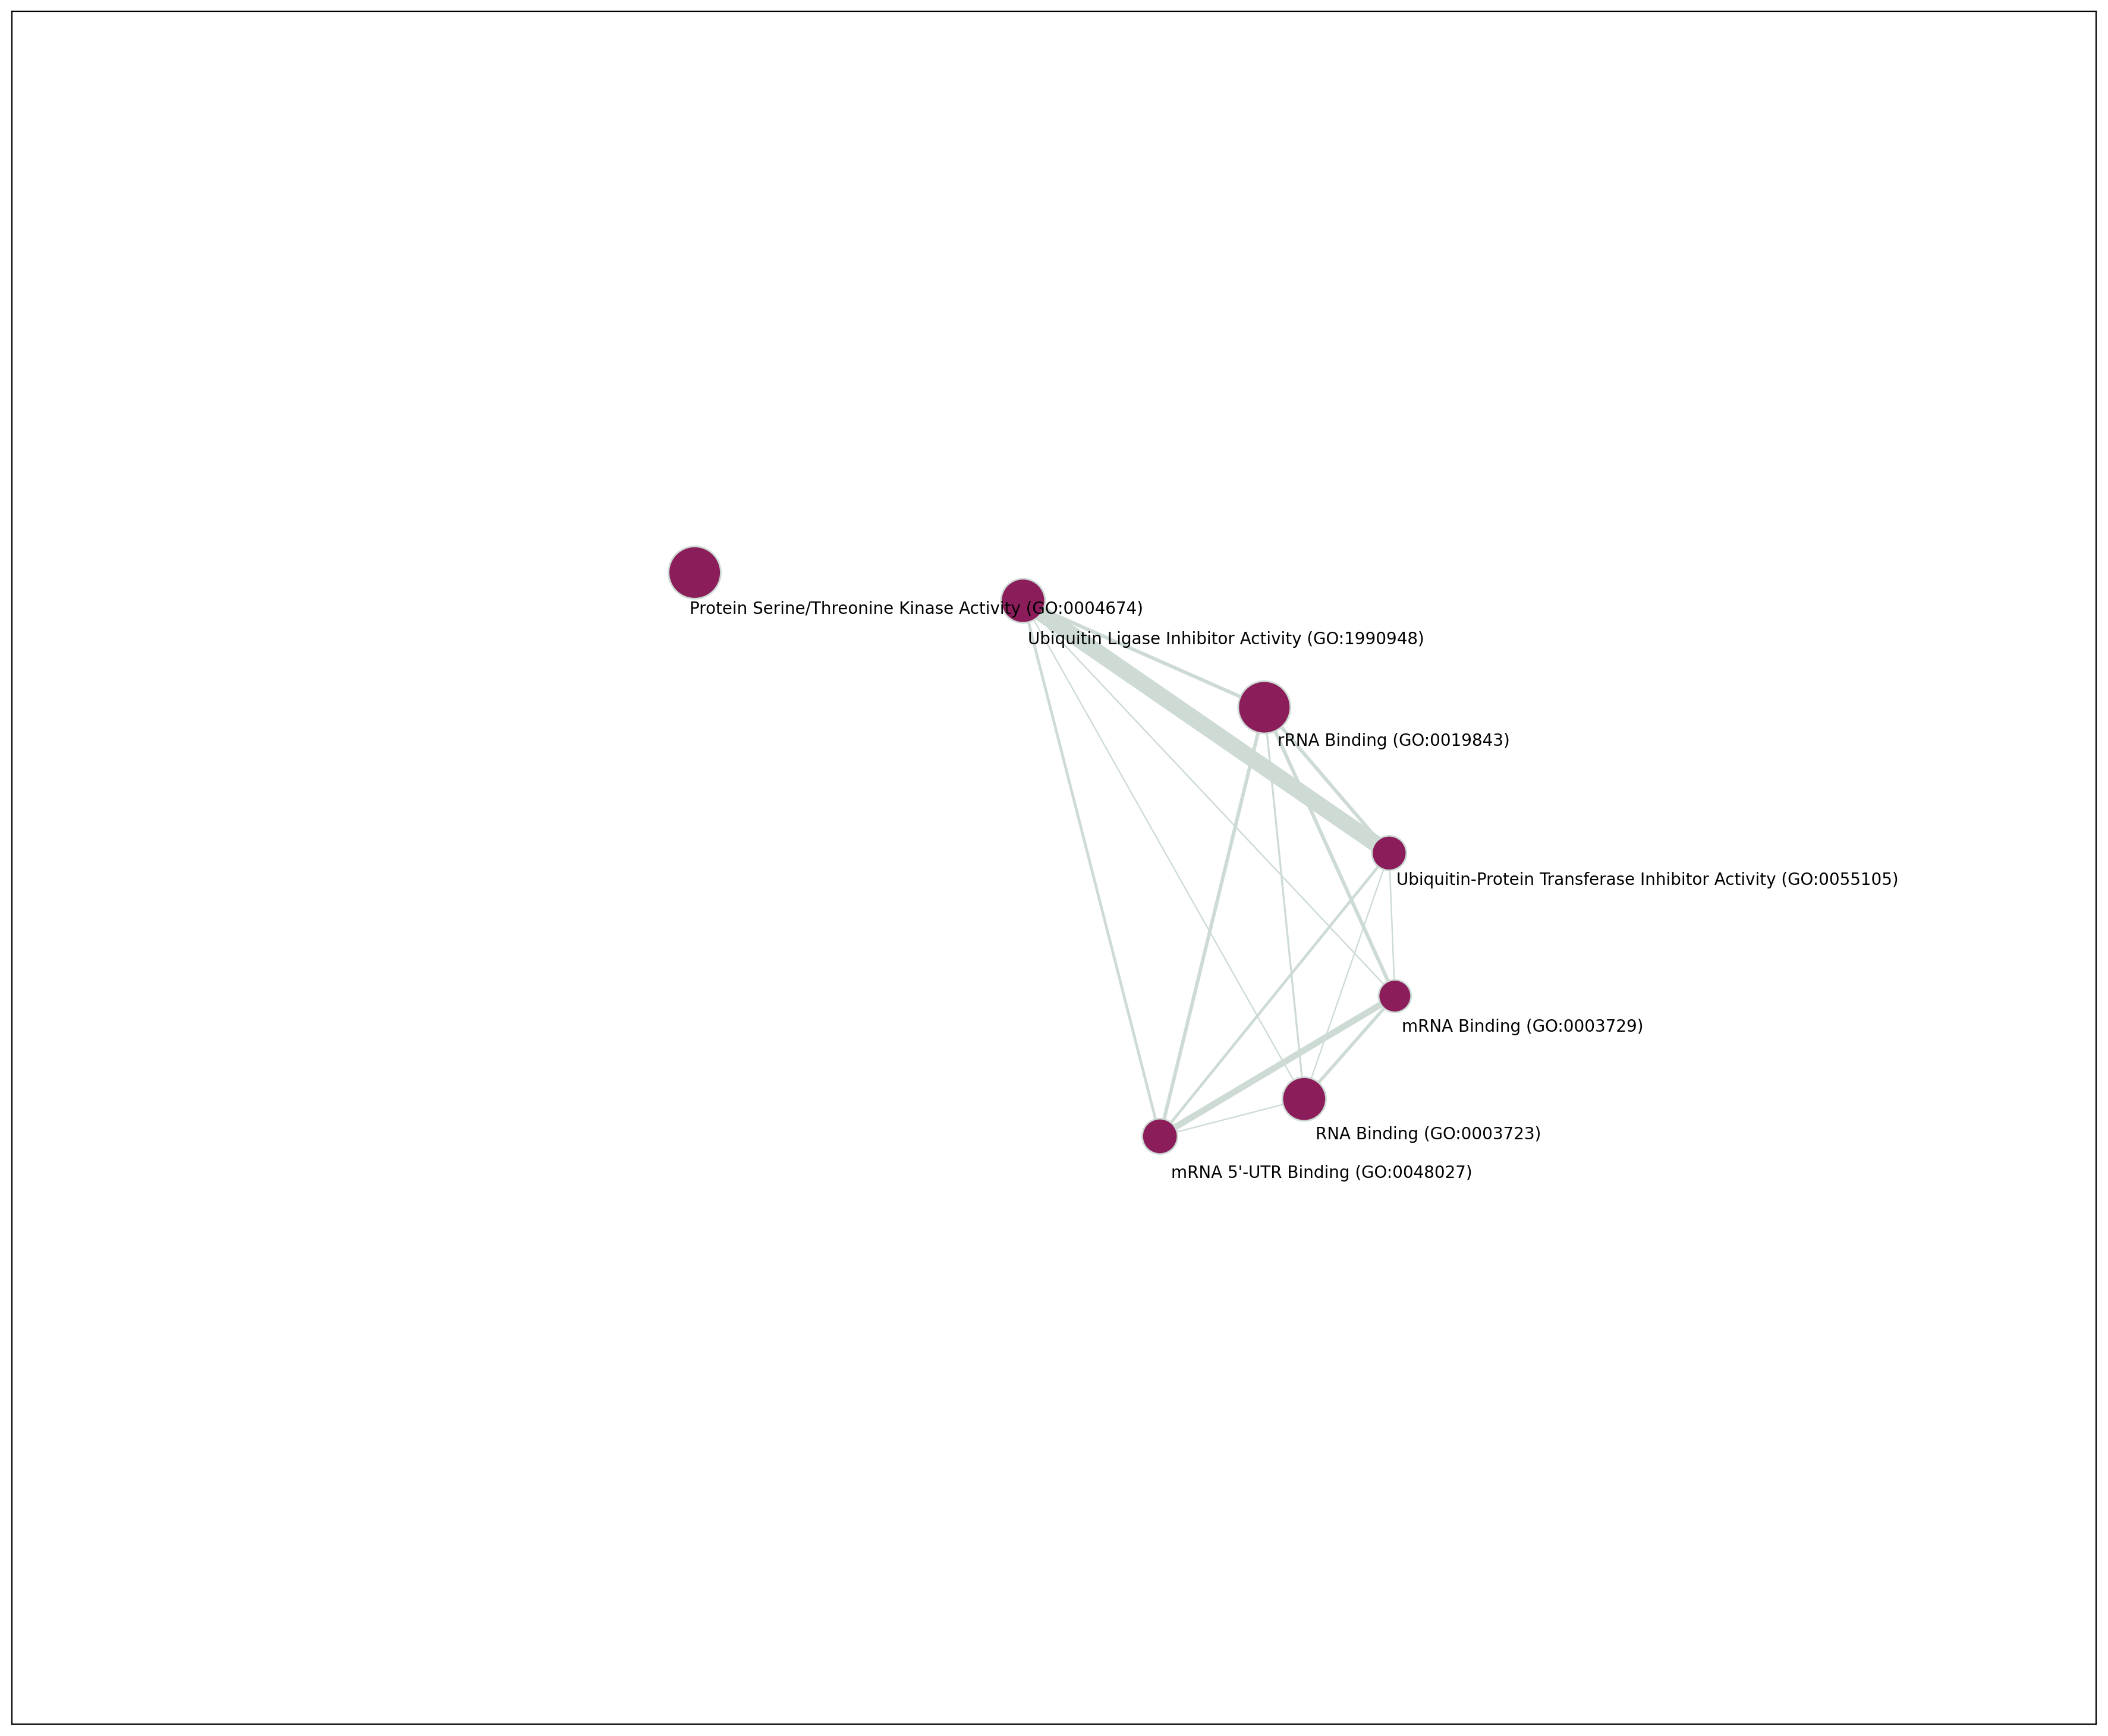

In [44]:
date = '08.13.25'
new_path = f'{date}/MT_PLS/GO_Molecular'
atlas = 'GO_Molecular_Function_2023'
pval = 0.05

# Use same normalization as in your heatmap
comp = 3
norm = mpl.colors.Normalize(vmin=0.50, vmax=0.65)
cmap = plt.get_cmap('rocket_r')

cell_type = 'Microglia'
sex_value = 'males'

value = results[cell_type][sex_value]['auc'][comp-1]
color = cmap(norm(value))
print(color)  # RGBA tuple

cell_type_paths_df = pd.DataFrame()

nz_gsea_df_sig = pd.read_csv(f'{new_path}/{cell_type}_comp_{comp}_hits.csv', index_col=0)

plot_network(nz_gsea_df_sig.loc[nz_gsea_df_sig['FDR q-val']<0.05], cell_type, comp, color)

[[0.86196552 0.16801239 0.27346473 1.        ]]
{0: 'Transmembrane Receptor Protein Tyrosine Kinase Activator Activity (GO:0030297)', 1: 'Voltage-Gated Potassium Channel Activity (GO:0005249)', 2: 'Tau Protein Binding (GO:0048156)', 3: "mRNA 3'-UTR Binding (GO:0003730)", 4: 'Phosphotyrosine Residue Binding (GO:0001784)', 5: 'Cell Adhesion Mediator Activity (GO:0098631)', 6: 'Oxidoreduction-Driven Active Transmembrane Transporter Activity (GO:0015453)', 7: 'Chemorepellent Activity (GO:0045499)', 8: 'Glutamate Receptor Activity (GO:0008066)', 9: 'Protein Phosphorylated Amino Acid Binding (GO:0045309)', 10: 'Protein Kinase Regulator Activity (GO:0019887)', 11: 'Semaphorin Receptor Binding (GO:0030215)', 12: 'MHC Class II Protein Complex Binding (GO:0023026)', 13: 'Ubiquitin-Protein Transferase Inhibitor Activity (GO:0055105)', 14: 'Ubiquitin Ligase Inhibitor Activity (GO:1990948)', 15: 'Ubiquitin Protein Ligase Binding (GO:0031625)', 16: 'RNA Binding (GO:0003723)', 17: 'mRNA Binding (GO:0

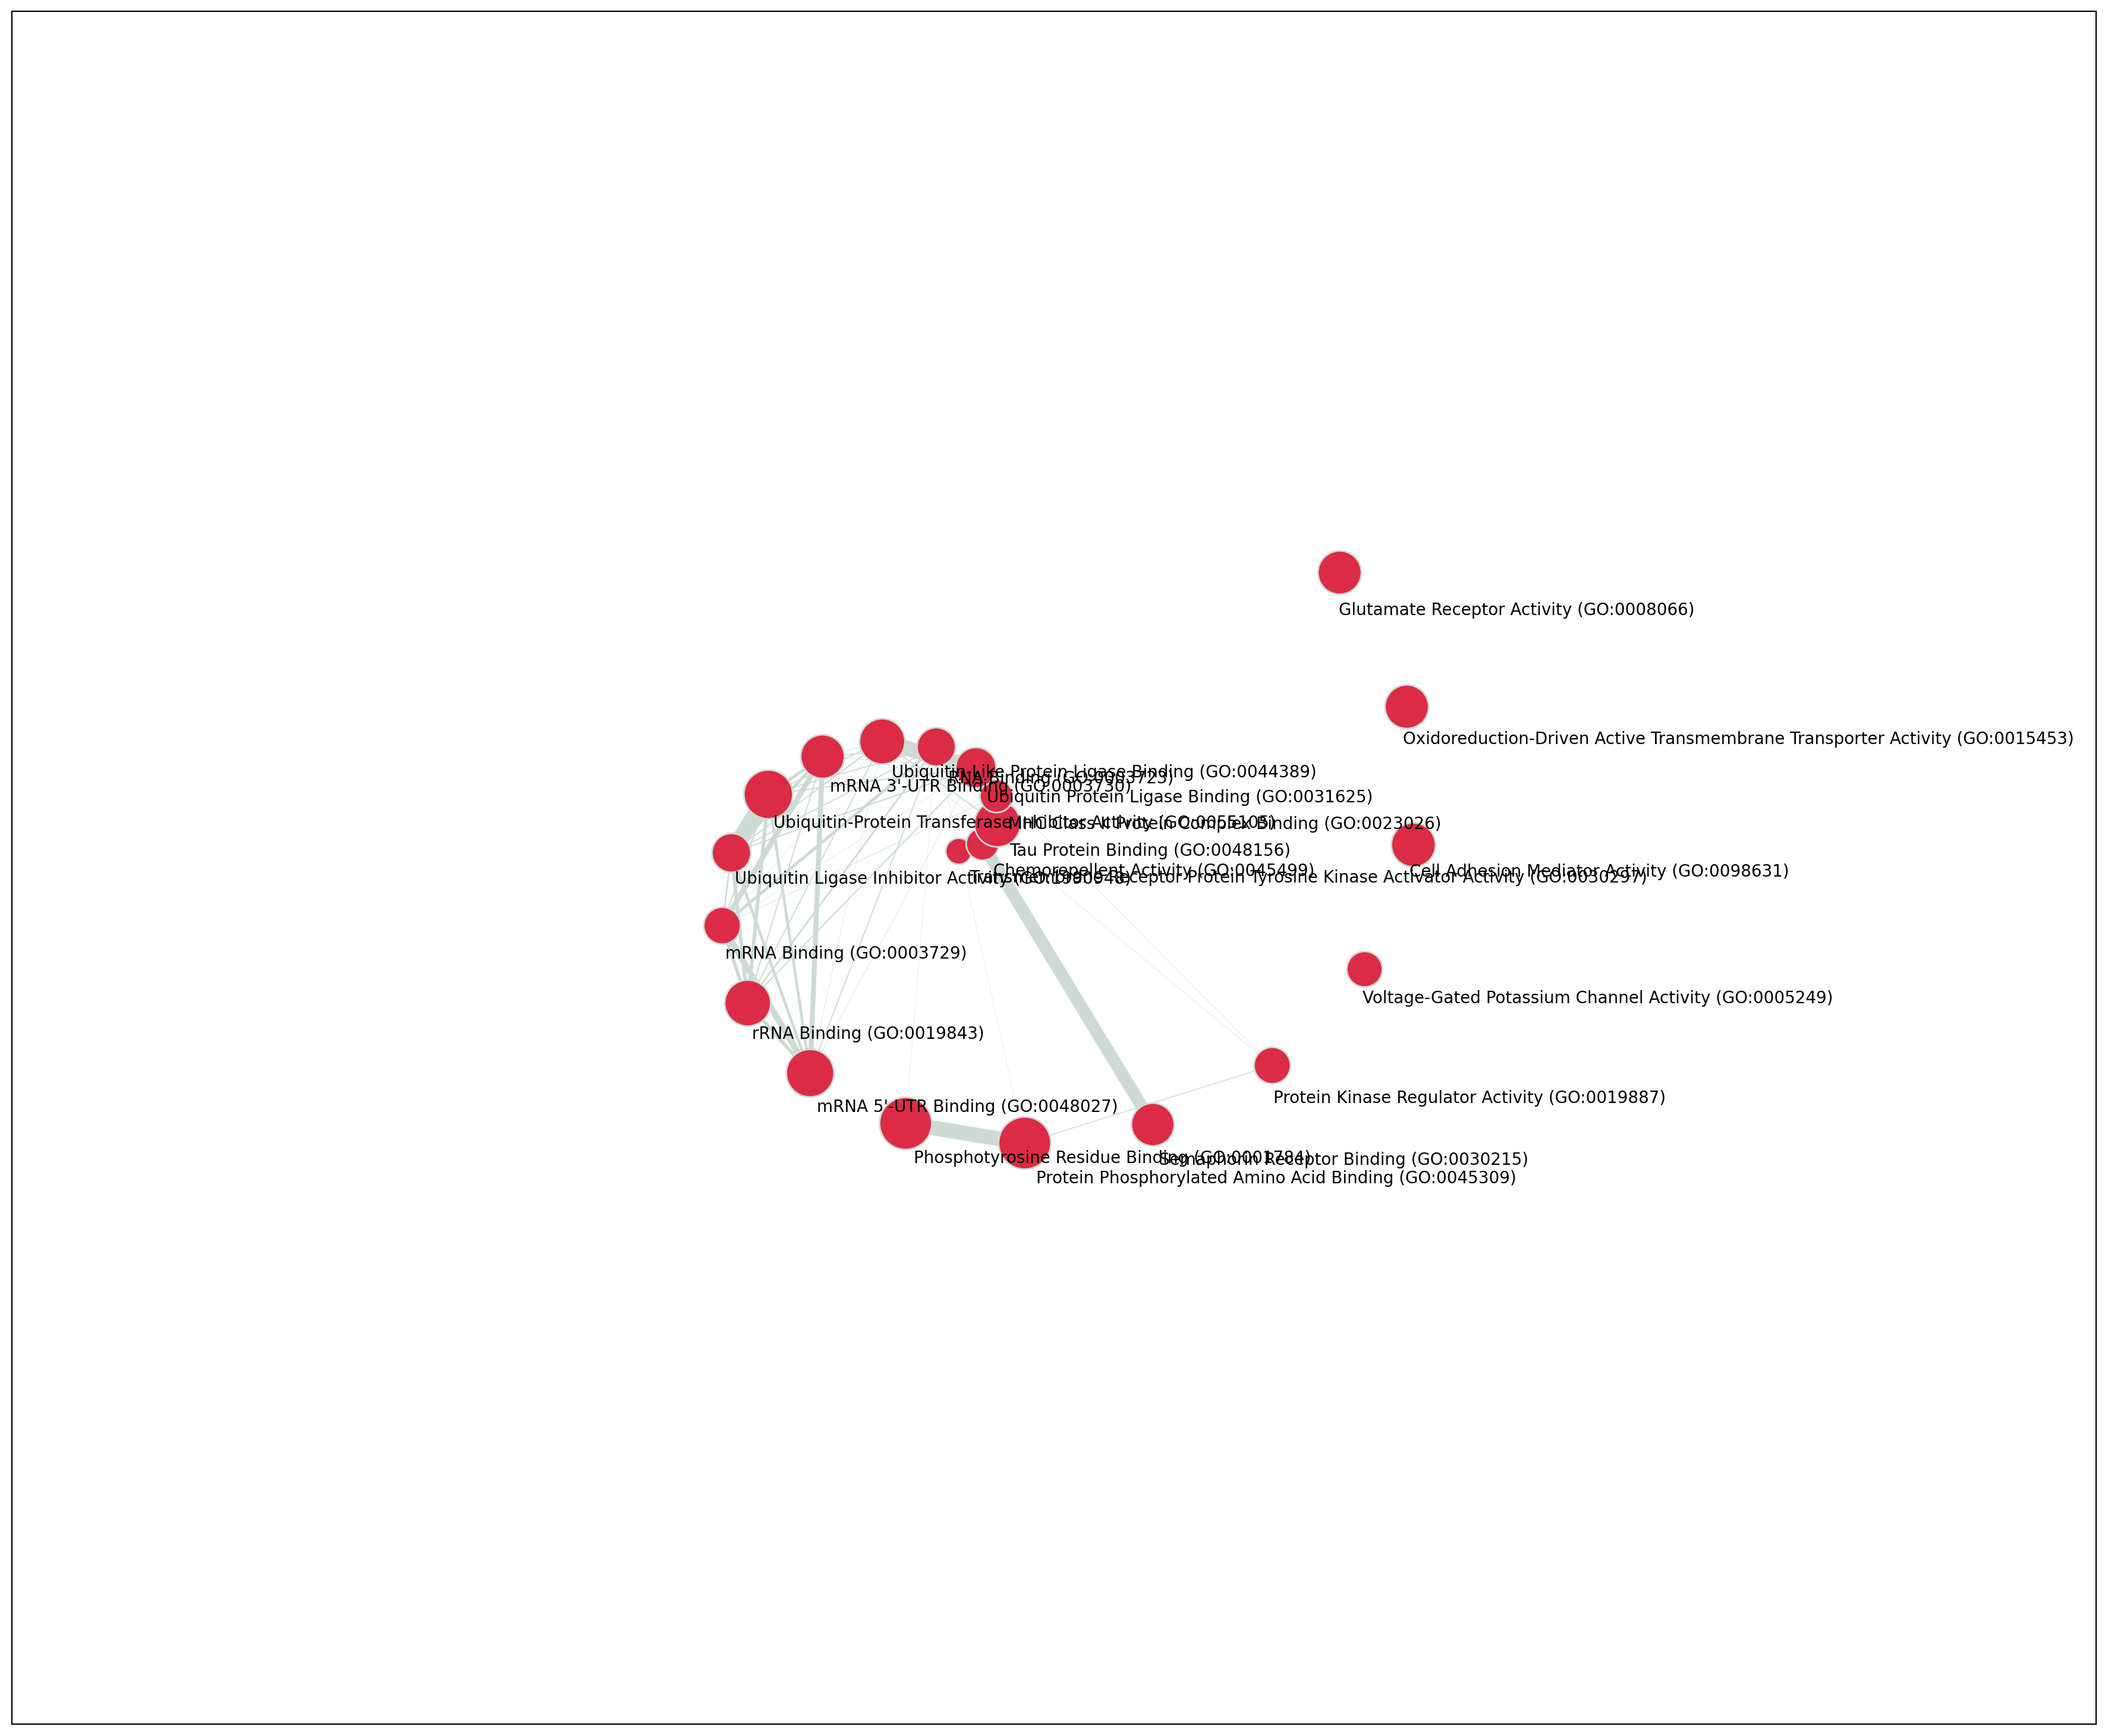

In [45]:
date = '08.13.25'
new_path = f'{date}/MT_PLS/GO_Molecular'
atlas = 'GO_Molecular_Function_2023'
pval = 0.05

# Use same normalization as in your heatmap
comp = 4
norm = mpl.colors.Normalize(vmin=0.50, vmax=0.65)
cmap = plt.get_cmap('rocket_r')

cell_type = 'Microglia'
sex_value = 'males'

value = results[cell_type][sex_value]['auc'][comp-1]
color = cmap(norm(value))
print(color)  # RGBA tuple

# loadings_df = pd.DataFrame(pls.x_loadings_,index=nuc_genes).loc[prot_genes]

cell_type_paths_df = pd.DataFrame()

nz_gsea_df_sig = pd.read_csv(f'{new_path}/{cell_type}_comp_{comp}_hits.csv', index_col=0)

plot_network(nz_gsea_df_sig.loc[nz_gsea_df_sig['FDR q-val']<0.05], cell_type, comp, color)

[[0.63139686 0.10067417 0.35664819 1.        ]]
{0: 'Disordered Domain Specific Binding (GO:0097718)', 1: 'Ubiquitin-Protein Transferase Inhibitor Activity (GO:0055105)', 2: 'Ubiquitin Ligase Inhibitor Activity (GO:1990948)', 3: 'Protein Heterodimerization Activity (GO:0046982)', 4: 'MHC Class II Protein Complex Binding (GO:0023026)', 5: 'Oxidoreductase Activity, Acting On The CH-OH Group Of Donors, NAD Or NADP As Acceptor (GO:0016616)', 6: 'Cholesterol Binding (GO:0015485)', 7: 'E-box Binding (GO:0070888)', 8: 'Serine-Type Peptidase Activity (GO:0008236)', 9: 'Purine Ribonucleoside Triphosphate Binding (GO:0035639)', 10: 'Ubiquitin Protein Ligase Binding (GO:0031625)', 11: 'Ubiquitin-Like Protein Ligase Binding (GO:0044389)', 12: 'Endopeptidase Inhibitor Activity (GO:0004866)', 13: "mRNA 5'-UTR Binding (GO:0048027)"}
{0: (0.29816019689607776, -0.00142008798968931), 4: (0.3684699801017498, 0.027142824806442784), 9: (0.416136125867671, 0.10191595004668959), 10: (0.4132389002716562, 0.20

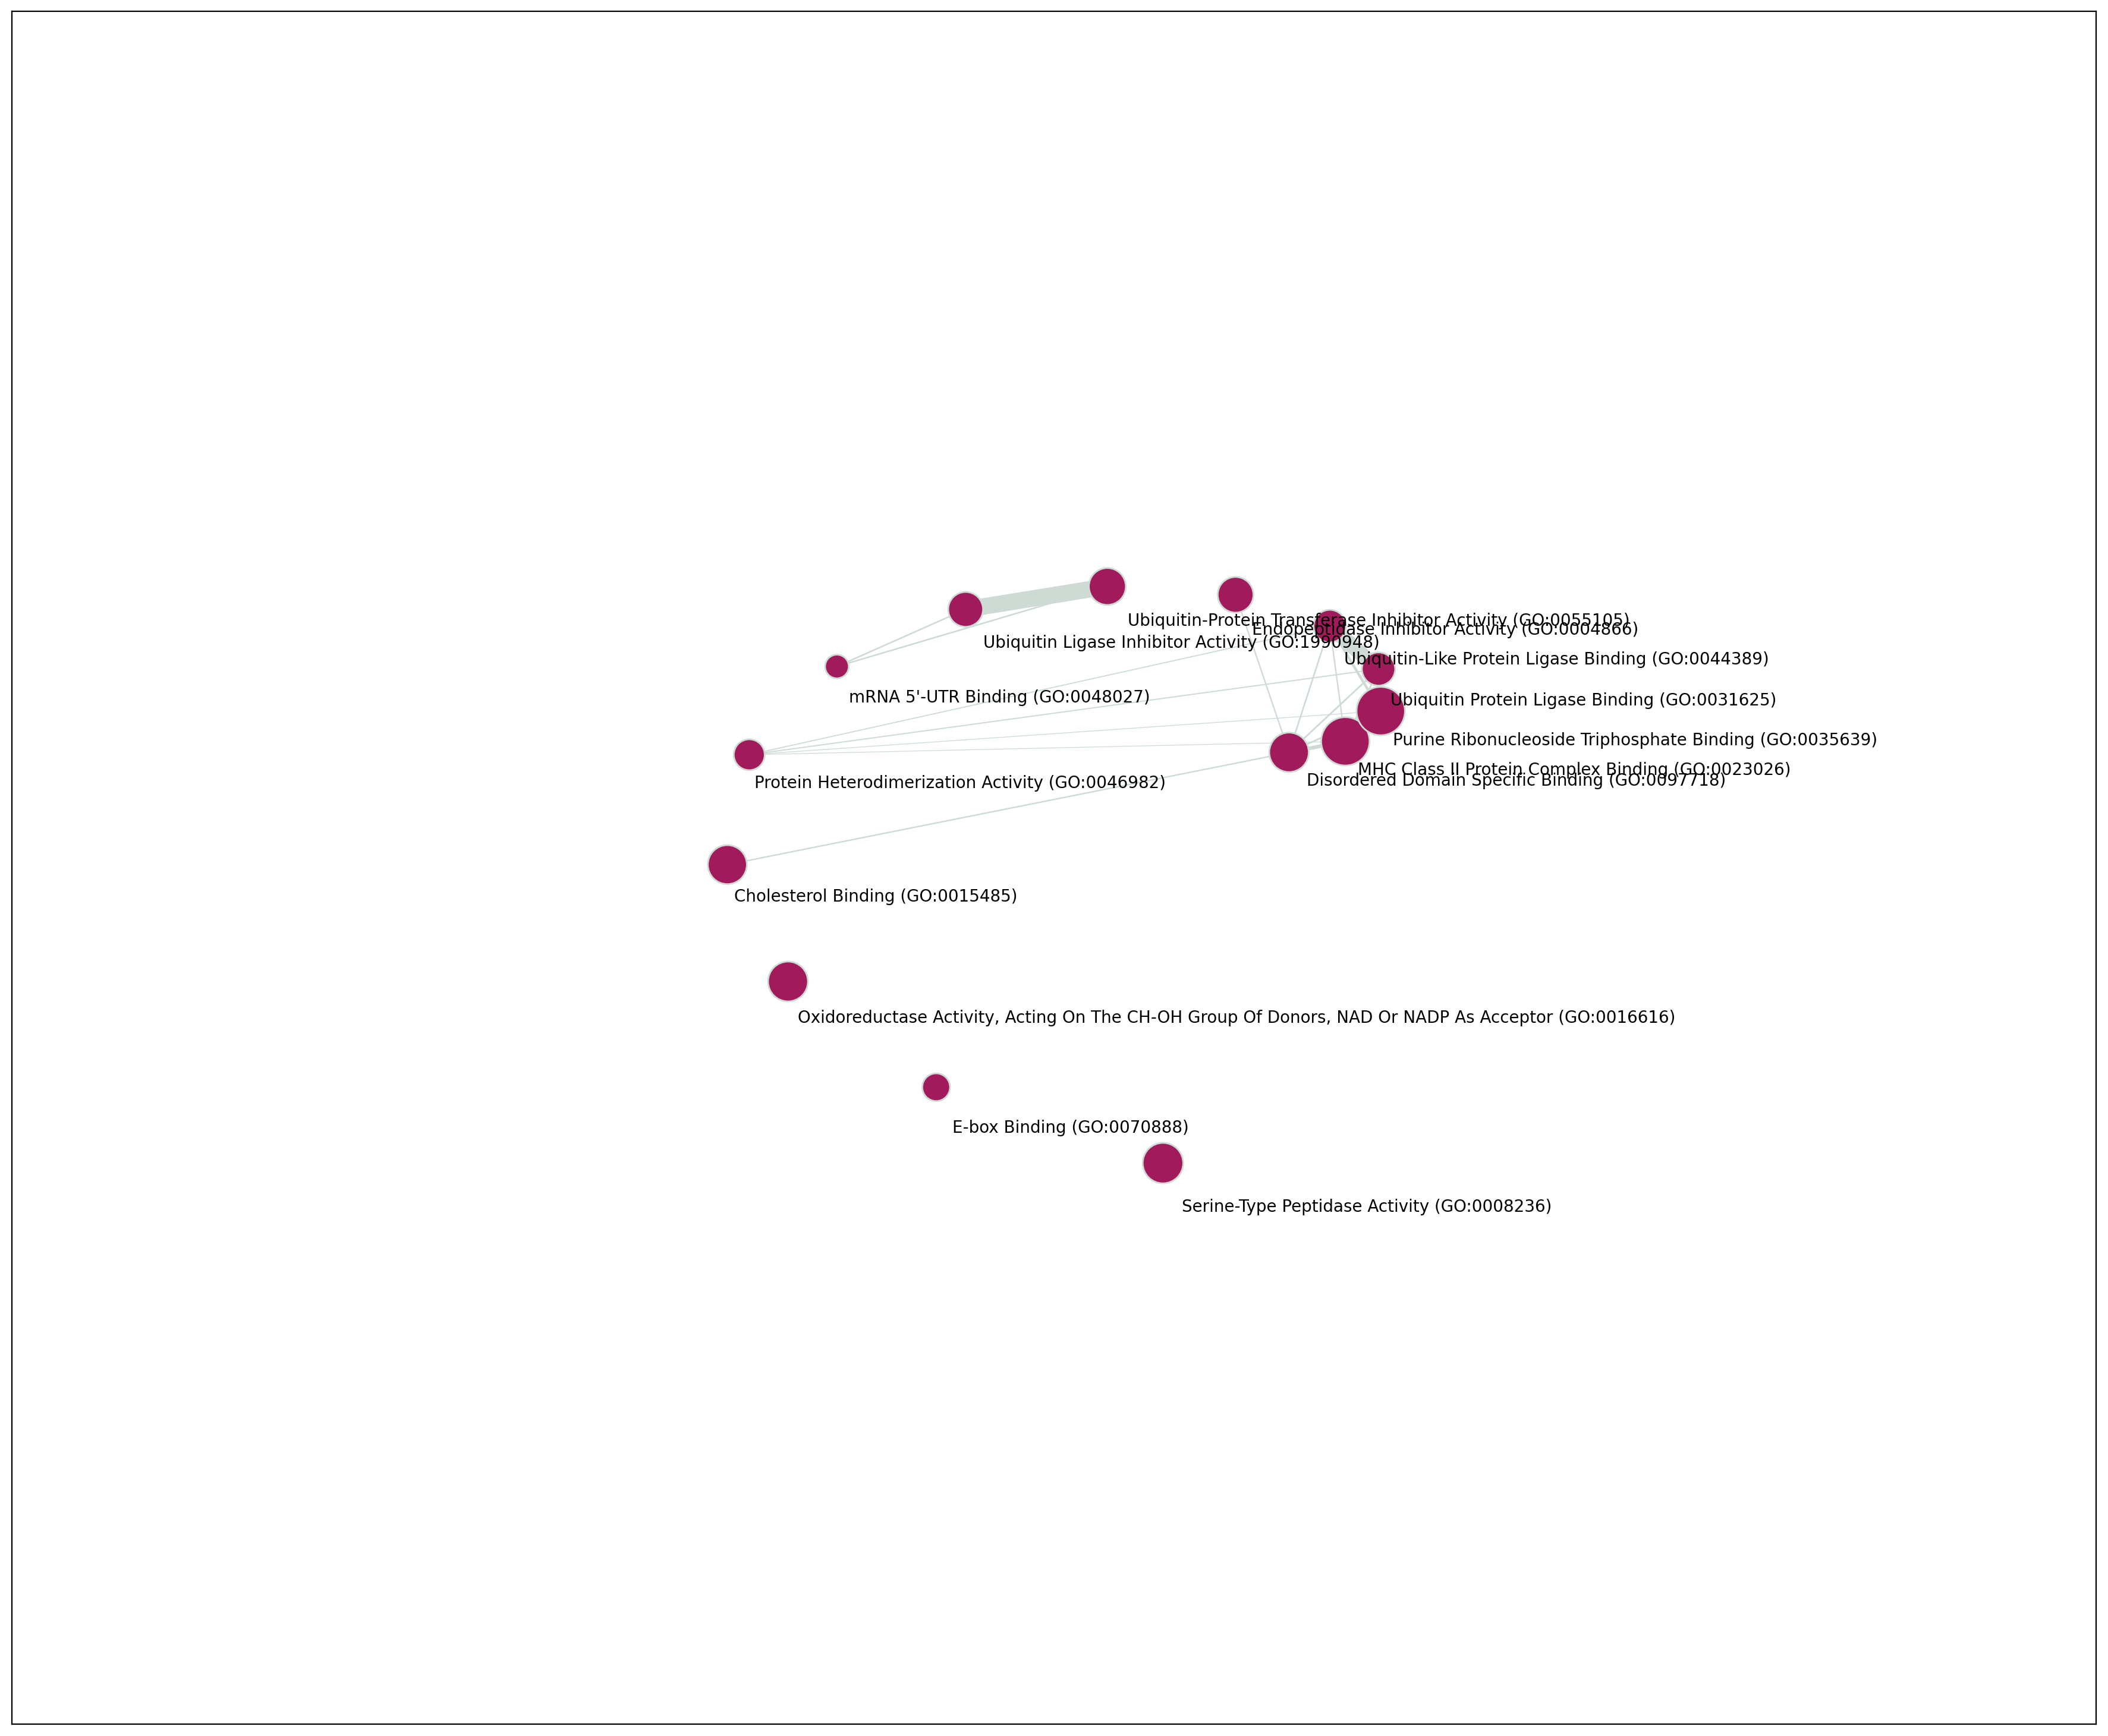

In [46]:
date = '08.13.25'
new_path = f'{date}/MT_PLS/GO_Molecular'
atlas = 'GO_Molecular_Function_2023'
pval = 0.05

# Use same normalization as in your heatmap
comp = 7
norm = mpl.colors.Normalize(vmin=0.50, vmax=0.65)
cmap = plt.get_cmap('rocket_r')

cell_type = 'OPCs'
sex_value = 'males'

value = results[cell_type][sex_value]['auc'][comp-1]
color = cmap(norm(value))
print(color)  # RGBA tuple

# loadings_df = pd.DataFrame(pls.x_loadings_,index=nuc_genes).loc[prot_genes]

cell_type_paths_df = pd.DataFrame()

nz_gsea_df_sig = pd.read_csv(f'{new_path}/{cell_type}_comp_{comp}_hits.csv', index_col=0)

plot_network(nz_gsea_df_sig.loc[nz_gsea_df_sig['FDR q-val']<0.05], cell_type, comp, color)

[[0.72398193 0.08688725 0.33943958 1.        ]]
{0: 'Phospholipase Activity (GO:0004620)', 1: 'Calcium Channel Regulator Activity (GO:0005246)', 2: 'Ubiquitin Ligase Inhibitor Activity (GO:1990948)', 3: 'Ubiquitin-Protein Transferase Inhibitor Activity (GO:0055105)', 4: 'NADH Dehydrogenase (Ubiquinone) Activity (GO:0008137)', 5: 'rRNA Binding (GO:0019843)', 6: 'RNA Binding (GO:0003723)', 7: 'NADH Dehydrogenase (Quinone) Activity (GO:0050136)', 8: 'Oxidoreduction-Driven Active Transmembrane Transporter Activity (GO:0015453)'}
{2: (0.24644018467821352, -0.5221392864059522), 3: (0.39165541366841095, -0.4642006414328564), 5: (0.48291018609271197, -0.30443535797763965), 6: (0.47752939743544265, -0.087897688876418), 4: (0.3453855569722788, 0.12675228110346648), 7: (0.10456197954417397, 0.2777993720670914), 8: (-0.2532155385255588, 0.31804764216126946), 0: (-0.6489114589705411, 0.2047082924855672), 1: (-1.01, -0.07429695796389746)}


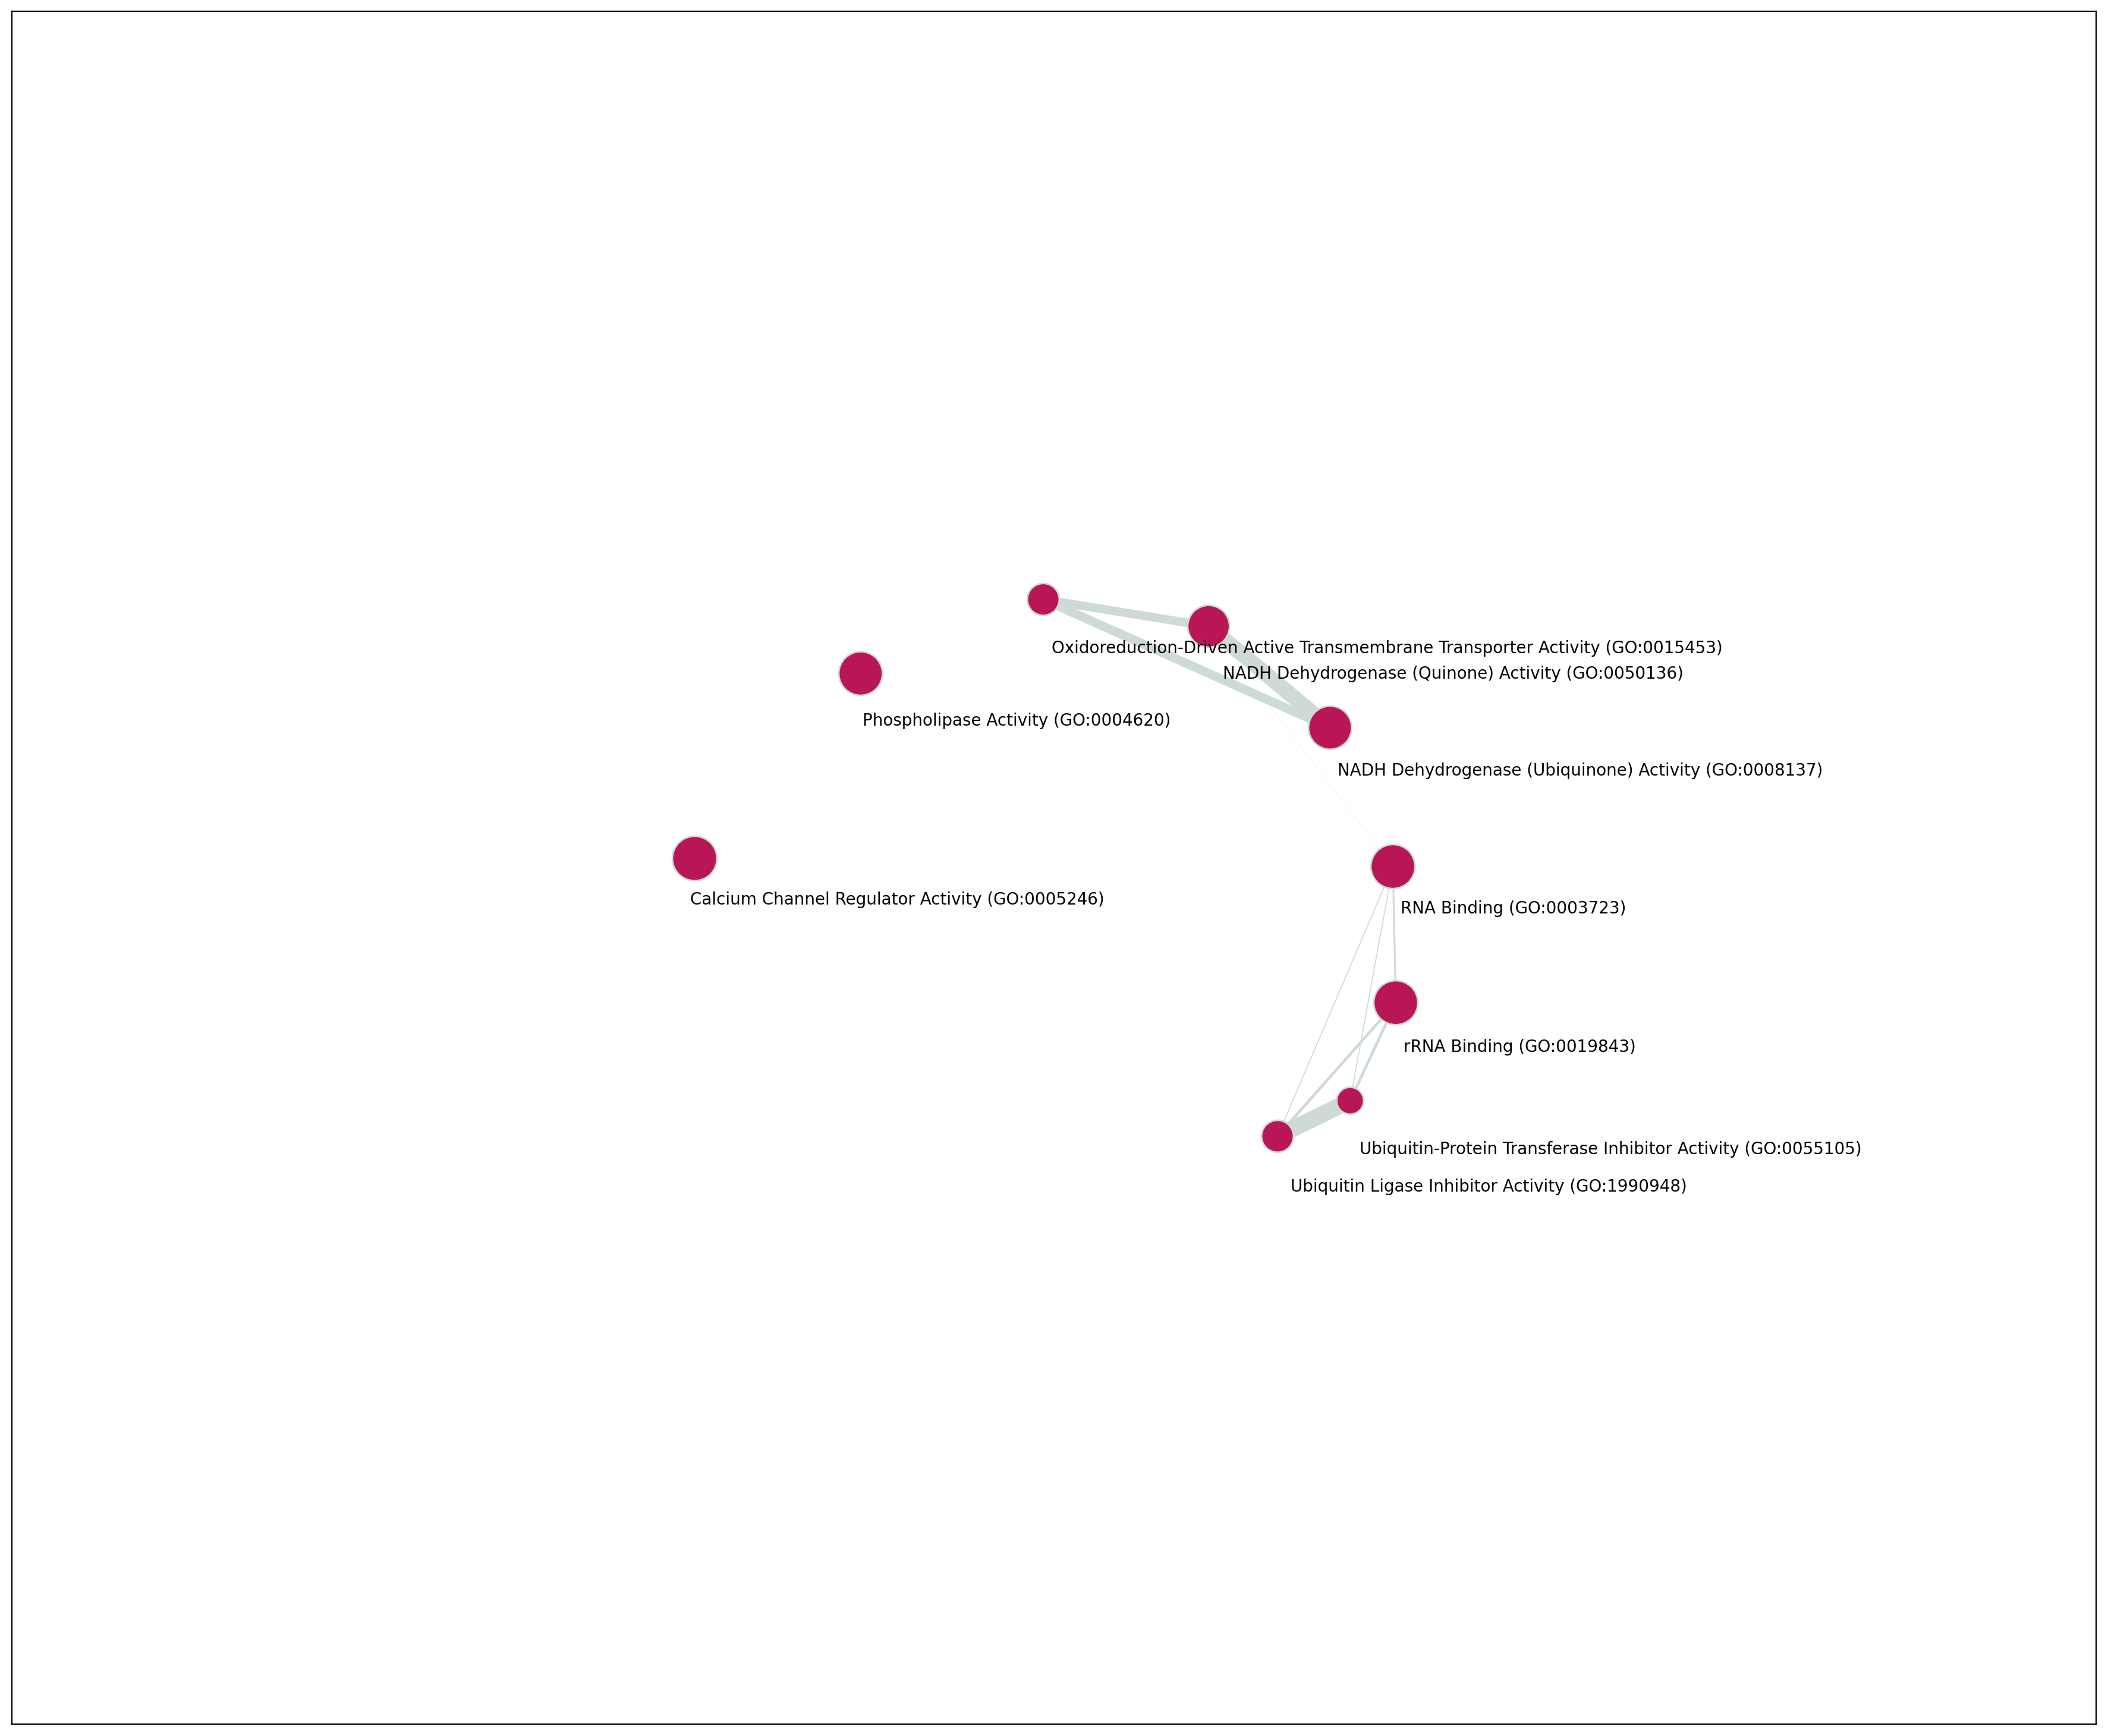

In [47]:
date = '08.13.25'
new_path = f'{date}/MT_PLS/GO_Molecular'
atlas = 'GO_Molecular_Function_2023'
pval = 0.05

# Use same normalization as in your heatmap
comp = 5
norm = mpl.colors.Normalize(vmin=0.50, vmax=0.65)
cmap = plt.get_cmap('rocket_r')

cell_type = 'Excitatory Neurons'
sex_value = 'females'

value = results[cell_type][sex_value]['auc'][comp-1]
color = cmap(norm(value))
print(color)  # RGBA tuple

# loadings_df = pd.DataFrame(pls.x_loadings_,index=nuc_genes).loc[prot_genes]

cell_type_paths_df = pd.DataFrame()

nz_gsea_df_sig = pd.read_csv(f'{new_path}/{cell_type}_comp_{comp}_hits.csv', index_col=0)

plot_network(nz_gsea_df_sig.loc[nz_gsea_df_sig['FDR q-val']<0.05], cell_type, comp, color)